# Load data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

import torch

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae

sns.set(style="whitegrid")
#sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

from vol_predict.backtest.benchmark_backtester import BenchmarkBacktester
from vol_predict.models.baselines.benchmarks import Naive

2025-05-16 21:27:16.068320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
)

full_vola = full_data.select(["datetime",'vol']).with_columns(
    lagged_vola=pl.col("vol").shift(1)
).to_pandas().set_index("datetime").dropna()

In [5]:
LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")
init_training_vola = full_vola.loc[:LAST_TRAINING_DATE]

<Axes: xlabel='datetime'>

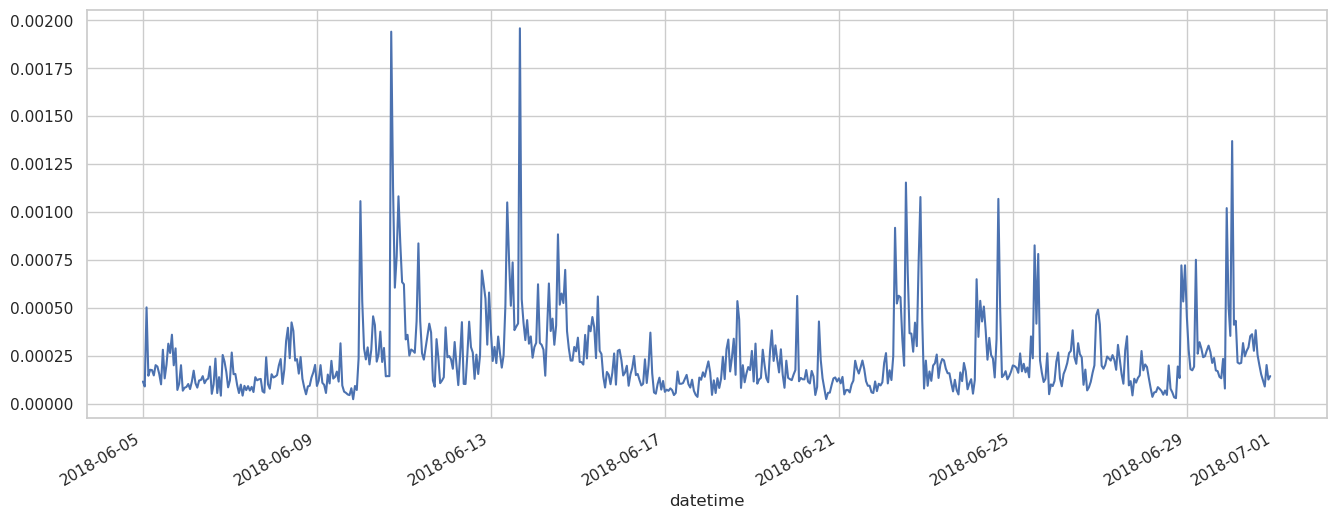

In [6]:
init_training_vola.loc[:,'vol'].plot()

<Axes: xlabel='datetime'>

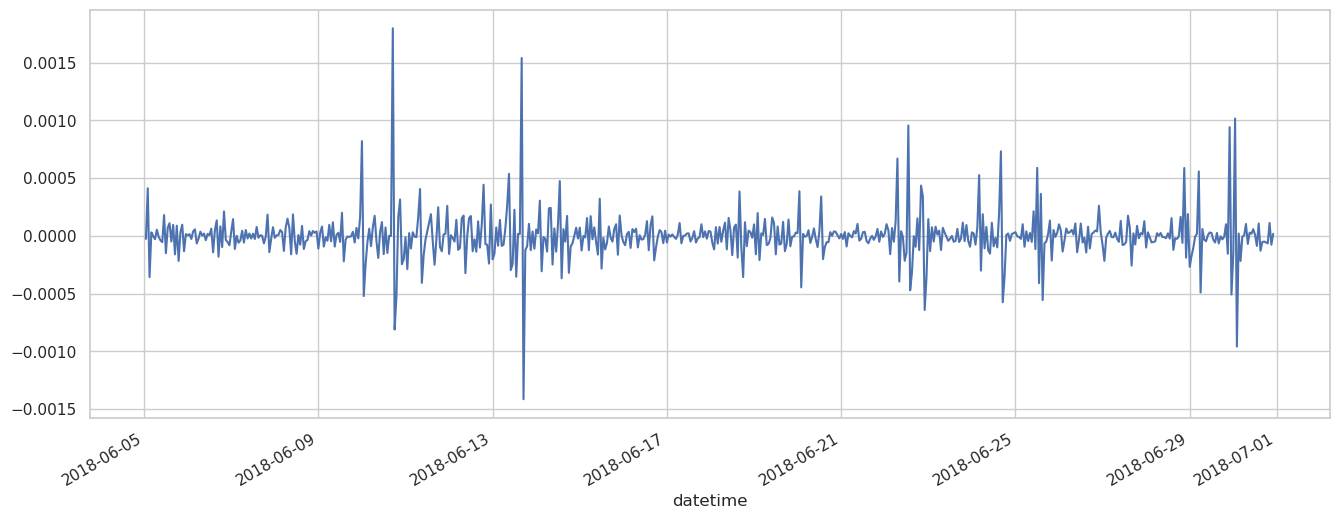

In [7]:
diff(init_training_vola.vol).plot()

(array([  6.,  24.,  57., 131., 140., 141.,  73.,  32.,  13.,   3.]),
 array([-10.6738671 , -10.2300322 ,  -9.78619731,  -9.34236241,
         -8.89852752,  -8.45469262,  -8.01085773,  -7.56702283,
         -7.12318794,  -6.67935305,  -6.23551815]),
 <BarContainer object of 10 artists>)

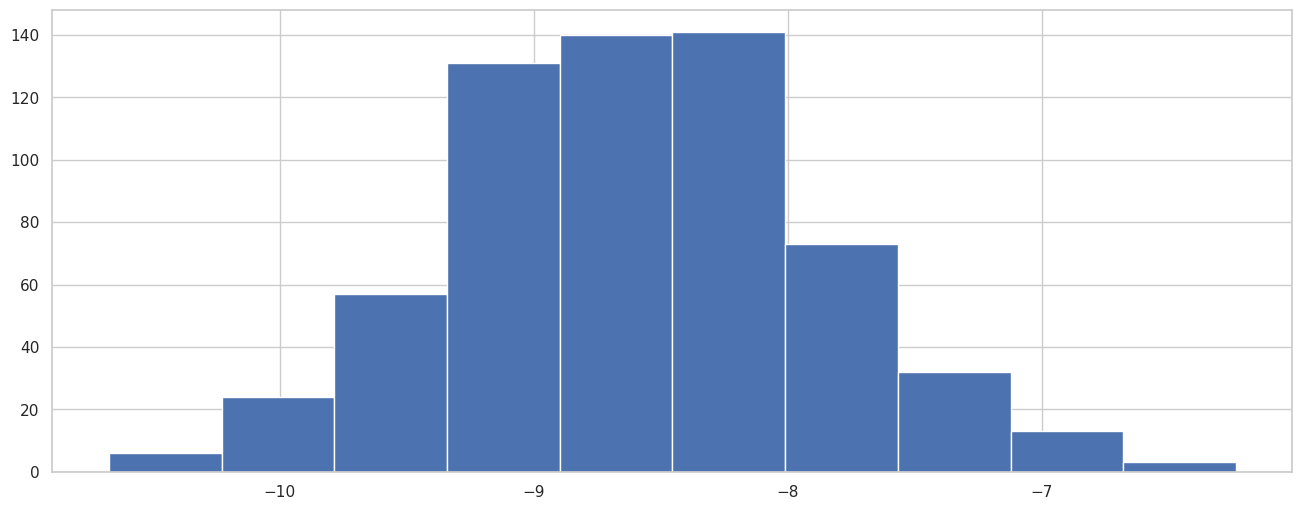

In [8]:
plt.hist(np.log(init_training_vola.vol))

## Stationarity tests

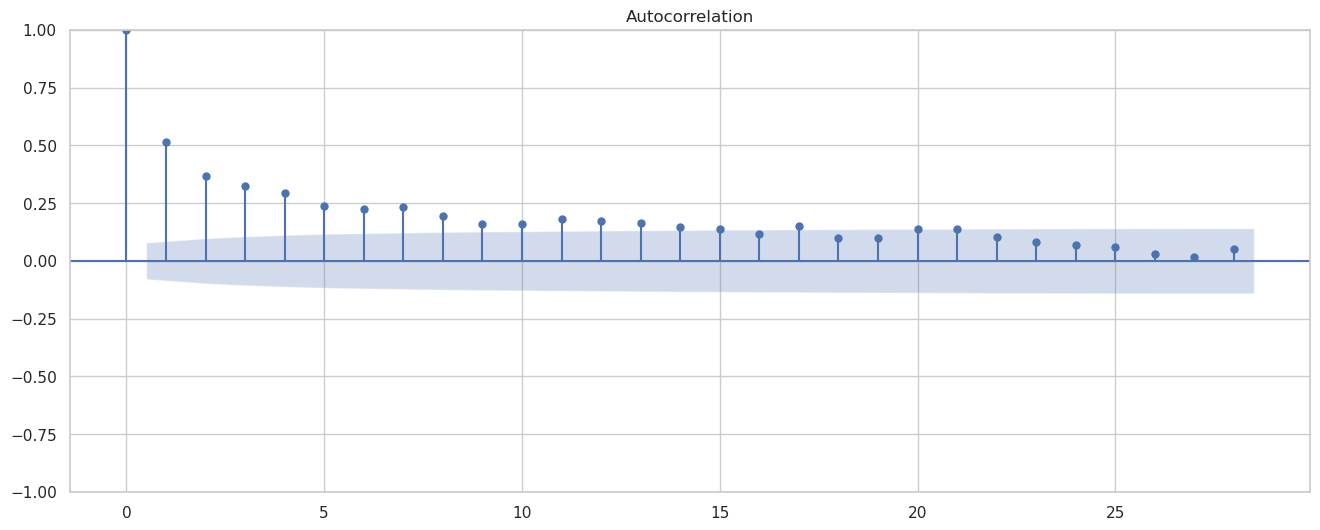

In [79]:
# acf and pcf plots
plot_acf(init_training_vola.vol, ax=None);


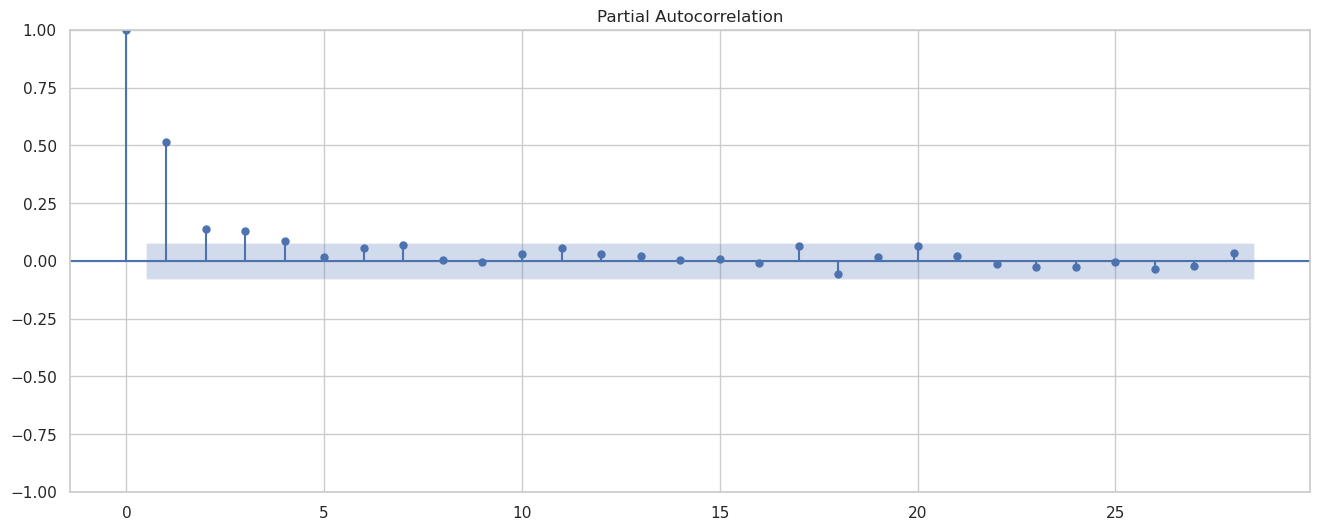

In [80]:
plot_pacf(init_training_vola.vol);

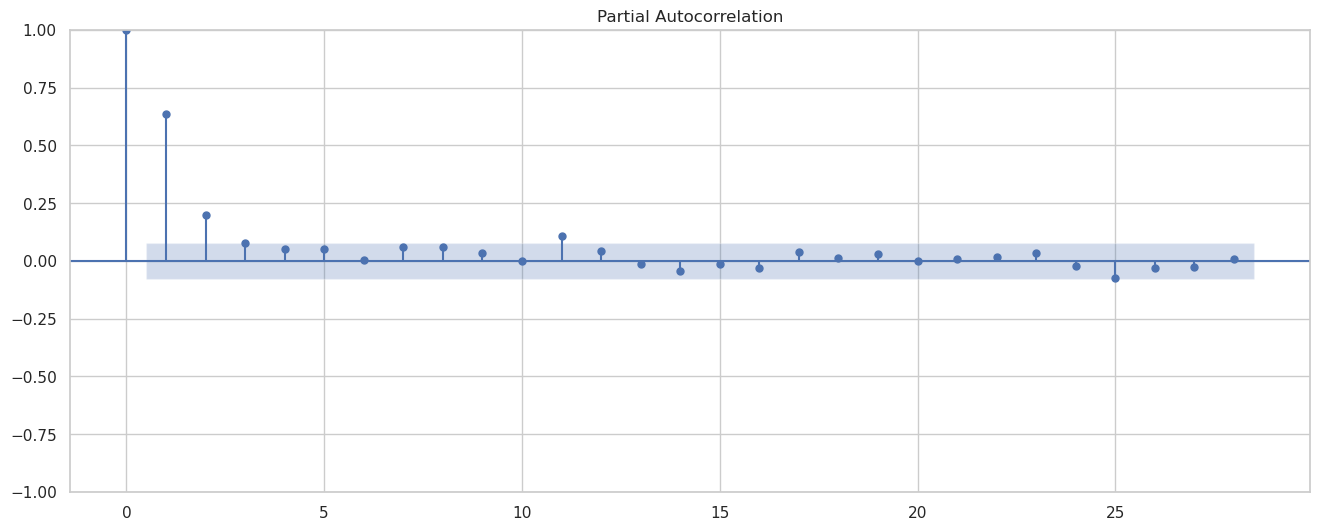

In [81]:
plot_pacf(np.log(init_training_vola.vol));

ACF is expected to have a slow decay and all positive autocorrelation coefficients.
PACF sharply goes to zero, a few positive significant lags and no seasonal spikes are present. 
Both results are due to "volatility clustering", but no long-term dependencies are present. 

### ADF

For maximal number of lags we use the default value (very large, orders of 100). For each number of lags, and each `regression` parameter in `c`, `ct`, `n` we compare AIC and BIC. 
`regression=c` minimizes both AIC and BIC, followed by `ct`. So we will test the null hypothesis of unit root with alternative of stationarity with a drift (constant) without the trend (which is obvious from the plot of differenced series of volatility). 


For AIC, the optimal number of lags is 3 whereas for BIC is 2. So we will choose 3 as the number of lags as PACF shows a bit longer memory then just 2 lags (it indicates 3 or maybe 4 lags).

In [82]:
adfuller(init_training_vola.vol, regression="c", autolag='AIC') # tweak the two parameters to get results stated above

(-7.404567388216078,
 7.4028332649633e-11,
 3,
 616,
 {'1%': -3.4410103235939746,
  '5%': -2.866243374831338,
  '10%': -2.5692748053002195},
 -8642.21908868115)

We can reject the null hypothesis of unit root with alternative of stationarity with a drift (constant).

### KPSS test

ADF is some weak of a test, so let's test the stationarity with KPSS test. The null hypothesis is a stationary process

In [83]:
def kpss_test(timeseries, regression):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


In [84]:
kpss_test(init_training_vola.vol.values, regression='c')

Results of KPSS Test:
Test Statistic            0.15874
p-value                   0.10000
Lags Used                13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/tmp/ipykernel_241663/2930837317.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags="auto")


We can not reject the null hypothesis of stationarity with a drift (constant). 

The KPSS with the alternative of stationarity with a trend (`regression='ct'`) has a significant p-value, but that is not relevant since we are confident there is not trend in volatility.

## Naive prediction

Naive prediction is the last observation of volatility.

TODO: take the gaps into account

In [6]:
full_vola.loc[LAST_TRAINING_DATE:]

,vol,lagged_vola
datetime,,
2018-07-03 23:00:00,0.000285,0.000144
2018-07-04 00:00:00,0.000241,0.000285
2018-07-04 01:00:00,0.000240,0.000241
2018-07-04 02:00:00,0.000173,0.000240
2018-07-04 03:00:00,0.000177,0.000173
...,...,...
2018-09-30 17:00:00,0.000025,0.000025
2018-09-30 18:00:00,0.000014,0.000025
2018-09-30 19:00:00,0.000024,0.000014


In [7]:
mse(
    full_vola.loc[LAST_TRAINING_DATE:, "vol"].values,
    full_vola.loc[LAST_TRAINING_DATE:, "lagged_vola"].values,
) ** 0.5

0.0002826151911814271

In [ ]:
mae(
    full_vola["vol"].values,
    full_vola["lagged_vola"].values,
) 

9.760723947542829e-05

There are gaps in the data, so we should be careful. Let's reavaluate only on the days with the previous observation available.

In [ ]:
vola_with_gaps = full_data.select(["datetime",'vol']).to_pandas().set_index("datetime").dropna()

In [ ]:
vola_with_gaps.loc[:,'prediction'] = None

In [ ]:
vola_with_gaps

,vol,prediction
datetime,,
2018-06-04 23:00:00,0.000143,None
2018-06-05 00:00:00,0.000115,None
2018-06-05 01:00:00,0.000090,None
2018-06-05 02:00:00,0.000502,None
2018-06-05 03:00:00,0.000146,None
...,...,...
2018-09-30 17:00:00,0.000025,None
2018-09-30 18:00:00,0.000014,None
2018-09-30 19:00:00,0.000024,None


In [ ]:
for i in range(vola_with_gaps.shape[0]):
    try:
        vola_with_gaps.loc[vola_with_gaps.index[i], 'prediction'] = vola_with_gaps.loc[vola_with_gaps.index[i]-pd.Timedelta(hours=1), 'vol']
    except:
        vola_with_gaps.loc[vola_with_gaps.index[i], 'prediction'] = None

In [ ]:
vola_with_gaps.prediction.isna().sum()

23

In [ ]:
naive_pred = vola_with_gaps.dropna()

In [ ]:
mse(
    naive_pred["vol"].values,
    naive_pred["prediction"].values,
) ** 0.5

0.0002676180620304086

In [ ]:
mae(
    naive_pred["vol"].values,
    naive_pred["prediction"].values,
)

9.789435196730884e-05

results without accounting for gaps

RMSE
0.0002666036074614381

MAE
9.760723947542829e-05

~difference at the third significant digit 

For the models with many past observations needed to predict the next observation, the gaps may be a problem.

## Exponentially Weighted Moving Average (EWMA)

$$
\hat{y}_t = \alpha \sum_{i=1}^T \beta^{t-i} y_{t-i}
$$

where:
- $\hat{y}_t$ is the forecast for time $t$
- $y_{t}$ is the observed value at time $t$ 
- $\alpha$ is the normalization factor,  `normlaization_factor` in code
- $\beta$ is the forgetting factor (0 < $\beta$ < 1), `forgetting_factor`
- $T$ is the number of observations, `ewma_look_back_win` 

Optimization is done on a `raw_forgetting_factor` which is on $\mathbb{R}$, mapping is done as
`forgetting_factor = torch.sigmoid(raw_forgetting_factor)`. The interpretable value of the forgetting factor is the half-life, and the method `EWMAPredictor.get_half_life()`  returns the half-life.

In [ ]:
class EWMAPredictor():
    """
    Exponentially Weighted Moving Average (EWMA) volatility predictor. Given the past volatility,
    average them by weighting the most recent ones more heavily. The forgetting factor and half-life
    are related as follows:

    forgetting_factor = 0.5 ** (1 / half_life)

    """

    def __init__(
        self,
        ewma_look_back_win: int,
        ewma_half_life: float,
        *args,
        **kwargs,
    ):
        #super().__init__()

        assert ewma_look_back_win > 0.0, "ewma_look_back_win must be greater than 0"
        assert ewma_half_life > 0.0,     "ewma_half_life must be greater than 0"
        self.look_back = ewma_look_back_win
        self.half_life = ewma_half_life
        self.forgetting_factor = self._hl_to_ff(torch.Tensor([self.half_life]))

        self.exp_weights = torch.zeros((self.look_back))
        for i in range(self.look_back):
            self.exp_weights[i] = self.forgetting_factor ** (i)

        self.normalization_const = (1 - self.forgetting_factor) / (
            1 - self.forgetting_factor**self.look_back
        )

        # # forgetting_factor is bounded between 0 and 1
        # # if needed, raw_forgetting_factor is an unbounded version of forgetting_factor
        # # sigmoid_inverse(3.4) = 0.9677, which is a forgetting_factor equivalent to half-life of 21
        # self.raw_forgetting_factor = Parameter(torch.Tensor([3.4]), requires_grad=True)
        # self.forgetting_factor = torch.sigmoid(self.raw_forgetting_factor)

    def _hl_to_ff(self, half_life: torch.Tensor) -> torch.Tensor:
        """
        Convert half-life to forgetting factor.
        """
        assert half_life.item() > 0.0, "half_life must be greater than 0"
        return torch.Tensor(0.5 ** (1 / half_life))

    def _ff_to_hl(self, forgetting_factor: torch.Tensor) -> torch.Tensor:
        """
        Convert forgetting factor to half-life.
        """
        assert forgetting_factor.item() > 0.0, (
            "forgetting_factor must be greater than 0"
        )
        assert forgetting_factor.item() < 1.0, "forgetting_factor must be less than 1"
        return -torch.log(torch.tensor(2.0)) / torch.log(
            torch.tensor(forgetting_factor)
        )

    def _forward(
        self,
        past_returns: torch.Tensor,
        past_vols: torch.Tensor,
        features: torch.Tensor,
        *args,
        **kwargs,
    ) -> torch.Tensor:

        calculation_win = min(self.look_back, past_vols.shape[0])
        if calculation_win == 0:
            return None
        elif calculation_win == self.look_back:
            return self.normalization_const * torch.sum(self.exp_weights * past_vols[-calculation_win:])
        else:
            # if we don't have enough data, we need to normalize the weights
            normalization_const = (1 - self.forgetting_factor) / (
                1 - self.forgetting_factor**calculation_win
            )
            return normalization_const * torch.sum(
                self.exp_weights[:calculation_win] * past_vols[-calculation_win:]
            )

### Tune `look_back` and `half_life` parameters

In [ ]:
# make a grid of look_back and half_life, and test the model
def test_ewma_predictor(
    ewma_look_back_win: int,
    ewma_half_life: float,
    volatility: torch.Tensor,
):
    """
    volatility: tensor of shape (n, 2), where n is the number of samples
    and the first column is the original volatility and the second column is the lagged volatility
    """
    ewma_predictor = EWMAPredictor(
        ewma_look_back_win=ewma_look_back_win, 
        ewma_half_life=ewma_half_life
    )

    predicted_vola = torch.zeros(volatility.shape[0])

    for i in range(ewma_look_back_win, len(predicted_vola)):
        predicted_vola[i] = ewma_predictor._forward(
            past_returns=None,
            past_vols=volatility[i-ewma_look_back_win:i, 1], # lagged vola column
            features=None,
        )

    rmse_ewma = mse(
        predicted_vola[ewma_look_back_win:],
        volatility[ewma_look_back_win:, 0], 
    ) ** 0.5
    mae_ewma = mae(
        predicted_vola[ewma_look_back_win:],
        volatility[ewma_look_back_win:, 0], 
    )

    l2_disp = ((predicted_vola[ewma_look_back_win:] - volatility[ewma_look_back_win:, 0])**2).std().sqrt().item()
    l1_disp = (predicted_vola[ewma_look_back_win:] - volatility[ewma_look_back_win:, 0]).std().item()

    return rmse_ewma, mae_ewma, l2_disp, l1_disp

In [ ]:
init_training_vola.shape

(620, 2)

In [ ]:
test_ewma_predictor(
    ewma_look_back_win=24,
    ewma_half_life=21,
    volatility=torch.tensor(init_training_vola.values),
)

(0.00021066792838729827,
 0.00013076106464554788,
 0.00042987075447090367,
 0.00021083351289346246)

In [ ]:
look_back_grid = [1, 3, 6, 12, 24, 48]
half_life_grid = [1, 3, 6, 12, 24, 48]
results = []
for look_back in look_back_grid:
    for half_life in half_life_grid:
        rmse_ewma, mae_ewma, l2_disp, l1_disp = test_ewma_predictor(
            ewma_look_back_win=look_back,
            ewma_half_life=half_life,
            volatility=torch.tensor(init_training_vola.values),
        )
        results.append(
            {
                "look_back": look_back,
                "half_life": half_life,
                "rmse": rmse_ewma,
                "mae": mae_ewma,
                "l2_disp": l2_disp,
                "l1_disp": l1_disp,
            }
        )
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["rmse", "mae"], ascending=[True, True])
results_df

,look_back,half_life,rmse,mae,l2_disp,l1_disp
23,12,48,0.000204,0.000126,0.000416,0.000204
17,6,48,0.000204,0.000126,0.000407,0.000204
16,6,24,0.000205,0.000126,0.000407,0.000205
22,12,24,0.000205,0.000126,0.000416,0.000205
15,6,12,0.000205,0.000127,0.000407,0.000205
21,12,12,0.000207,0.000128,0.000417,0.000207
14,6,6,0.000207,0.000128,0.000406,0.000207
29,24,48,0.000208,0.000129,0.000427,0.000209
11,3,48,0.000210,0.000123,0.000424,0.000210
10,3,24,0.000210,0.000123,0.000423,0.000210


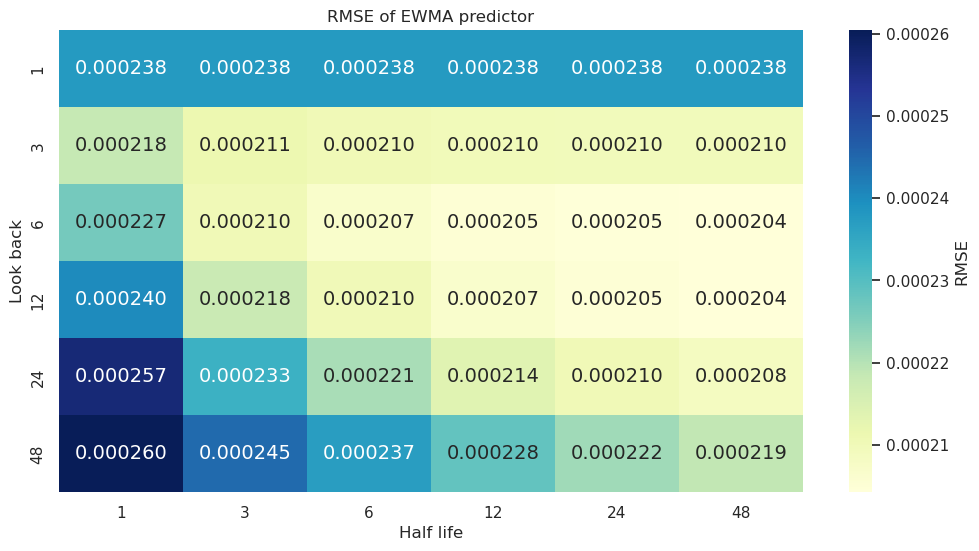

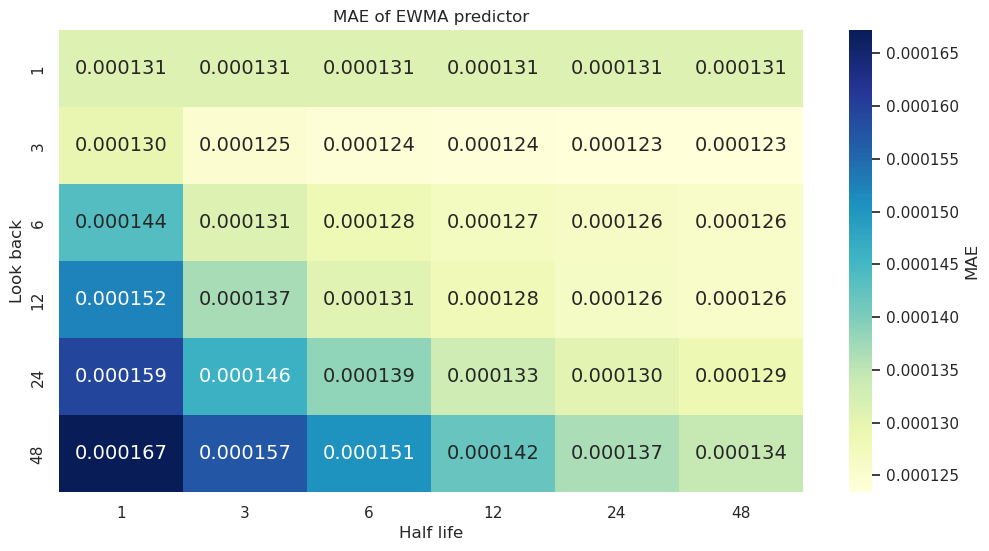

In [ ]:
# plot heatmap of rmse and mae
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="rmse",),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    cbar_kws={"label": "RMSE"},
)
plt.title("RMSE of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="mae",),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    cbar_kws={"label": "MAE"},
)
plt.title("MAE of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()

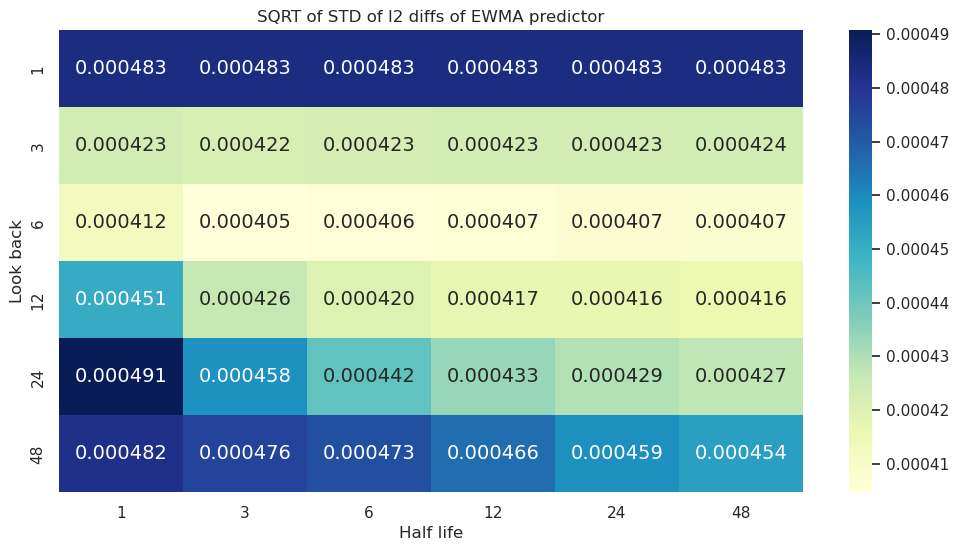

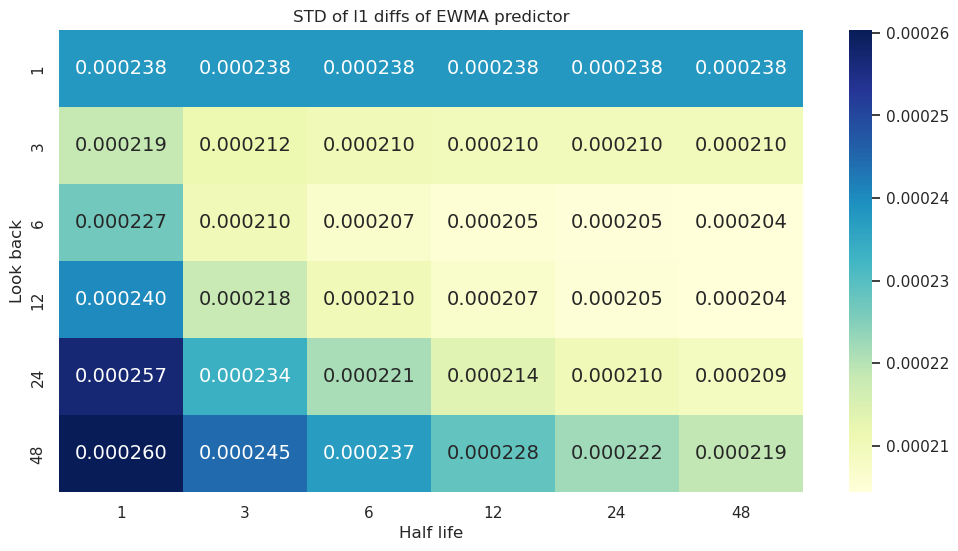

In [ ]:
# plot heatmap of l1 and l2 residuals dispersion
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="l2_disp",),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    #cbar_kws={"label": "RMSE STD"},
)
plt.title("SQRT of STD of l2 diffs of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="l1_disp",),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    #cbar_kws={"label": "MAE STD"},
)
plt.title("STD of l1 diffs of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()

We will pick the parameters such that both RMSE and MAE are near the optimal values obtained in the previous test.

Increasing half-life increases the performance in both metrics, but the difference is negligible after 12 or 24 days.

For RMSE the optimal look-back window is 6, with 12 following closely. 
For MAE the optimal look-back window is 6 and 12 are similar results.

We will chose 12 days for look-back window and 12 for the half-life. 6 days of look-back would be optimal for RMSE, but given a relatively small difference we will choose the 12 days for the sake of robustness and to make the exponential decay more pronounced (given that the half-life is 12 days, 6 days look-back would be close to a simple moving average).

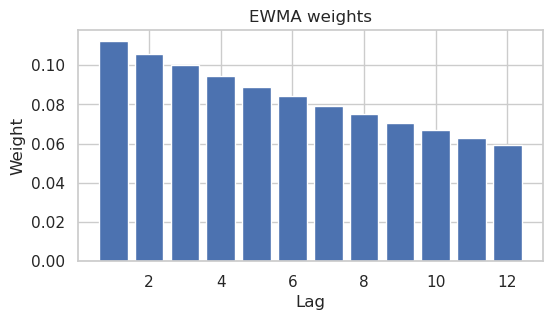

In [ ]:
# plot histogram of weights
ewma_predictor = EWMAPredictor(
    ewma_look_back_win=12, 
    ewma_half_life=12
)

plt.figure(figsize=(6, 3))
plt.bar(
    range(1,ewma_predictor.look_back+1),
    ewma_predictor.exp_weights.detach().numpy() * ewma_predictor.normalization_const.detach().numpy(),
)
plt.title("EWMA weights")
plt.xlabel("Lag")
plt.ylabel("Weight")
plt.show()

### Optimal EWMA

In [ ]:
LOOK_BACK_WIN = 12
HALF_LIFE = 12
ewma_predictor = EWMAPredictor(
    ewma_look_back_win=LOOK_BACK_WIN,
    ewma_half_life=HALF_LIFE,
)

In [ ]:
vola_tensor = torch.tensor(full_vola.values)

In [ ]:
predicted_vola = torch.zeros((len(vola_tensor)))

for i in range(LOOK_BACK_WIN, len(vola_tensor)):
    # original vola_tensor[i-LOOK_BACK_WIN:i,0]
    # lagged   vola_tensor[i-LOOK_BACK_WIN:i,1]

    predicted_vola[i] = ewma_predictor._forward(
        past_returns=None,
        past_vols=vola_tensor[i-LOOK_BACK_WIN:i, 1], # lagged vola column
        features=None,
    )

In [ ]:
mse(predicted_vola[LOOK_BACK_WIN:].numpy(), 
    vola_tensor[LOOK_BACK_WIN:, 0].numpy()) ** 0.5

0.00024105136934586283

In [ ]:
mae(predicted_vola[LOOK_BACK_WIN:].numpy(), 
    vola_tensor[LOOK_BACK_WIN:, 0].numpy())

0.00010302251197627743

## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

In [ ]:
#Determines the p and q that minimizes the AIC
def find_p_q(ts, max_p, max_q):
    p_q_table = pd.DataFrame(index=range(max_p + 1), columns=range(max_q + 1))
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            model = ARIMA(ts, order=(p, 0, q))
            fit = model.fit(method_kwargs={'maxiter':1000})
            p_q_table.loc[p, q] = fit.aic
    return p_q_table

#Plots the residuals including their density
def plot_residuals(model):
    resids = model.resid[1:]
    fig, ax = plt.subplots(1,2)
    resids.plot(title='Residuals', ax=ax[0])
    resids.plot(title='Density', kind = 'kde', ax = ax[1])
    plt.show()

In [ ]:
# make p, q mash
p_max = 5
q_max = 5

In [ ]:
aic_p_q = find_p_q(
    init_training_vola.vol.values,
    max_p=p_max,
    max_q=q_max,
)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mirosl

In [ ]:
aic_p_q

,0,1,2,3,4,5
0,-8729.921141,-8861.617538,-8890.723675,-8904.51553,-8917.81636,-8920.421815
1,-8918.570157,-8936.669456,-8944.226726,-8942.821677,-8939.737345,-8940.597352
2,-8928.662338,-6572.457253,-8941.287418,-8940.809037,-8938.212333,-8938.555541
3,-8936.700678,-8932.176202,-8939.785832,-8938.172002,-8933.972213,-8937.192802
4,-8939.372412,-8936.873509,-8718.35949,-8938.323936,-8934.456006,-8930.889921
5,-8937.581659,-8935.172413,-8936.014442,-8714.359389,-8712.359247,-8926.770694


<Axes: >

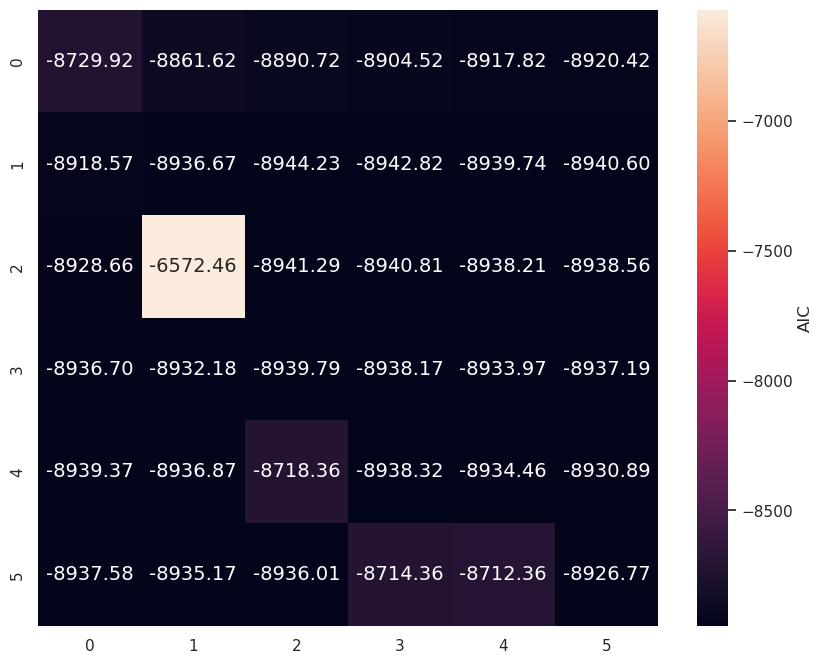

In [ ]:
# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    aic_p_q.astype(float),
    annot=True,
    fmt=".2f",
    #cmap="YlGnBu",
    cbar_kws={"label": "AIC"},
)

In [ ]:
# find the best p, q
best_p, best_q = np.unravel_index(
    np.argmin(aic_p_q.values), aic_p_q.shape
)
print(f"Best p: {best_p}, Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

Best p: 1, Best q: 2
Best AIC: -8944.226726248375


In [ ]:
arima = ARIMA(
    endog=init_training_vola.vol.values,
    order=(best_p, 0, best_q), 
)
arima_results = arima.fit(method_kwargs={'maxiter':1000})
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  620
Model:                 ARIMA(1, 0, 2)   Log Likelihood                4477.113
Date:                Mon, 12 May 2025   AIC                          -8944.227
Time:                        14:22:03   BIC                          -8922.078
Sample:                             0   HQIC                         -8935.617
                                - 620                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   3.66e-05      6.566      0.000       0.000       0.000
ar.L1          0.8782   3.37e-08   2.61e+07      0.000       0.878       0.878
ma.L1         -0.4622   2.18e-08  -2.12e+07      0.000      -0.462      -0.462
ma.L2         -0.1248    1.1e-08  -1.13e+07      0.000      -0.125      -0.125
sigma2      3.126e-08   6.79e-10     46.027      0.000    2.99e-08    3.26e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             25217.97
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             4.30
Prob(H) (two-sided):                  0.12   Kurtosis:                        33.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.01e+22. Standard errors may be unstable.
"""

Ljung-Box indicates that there is some autocorrelation in the residuals.

Jarque-Bera test indicates that residuals are not distributed normally. 

Using BIC as a criterion yields the same (p,q)

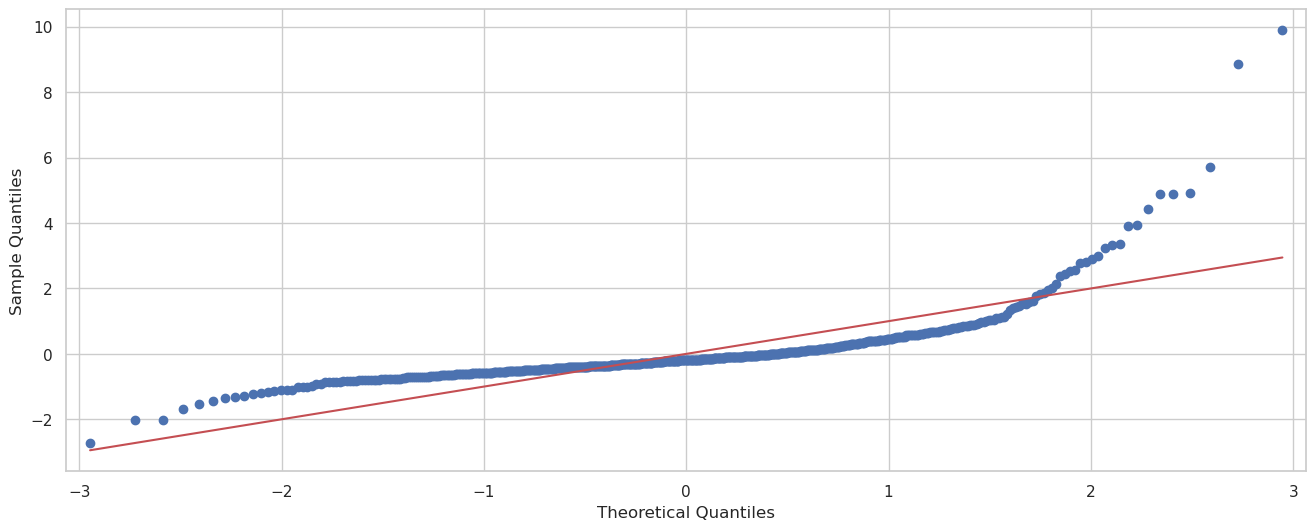

In [ ]:
# qq plot of residuals
sm.qqplot(
    arima_results.resid,
    line="s",
    fit=True,
);

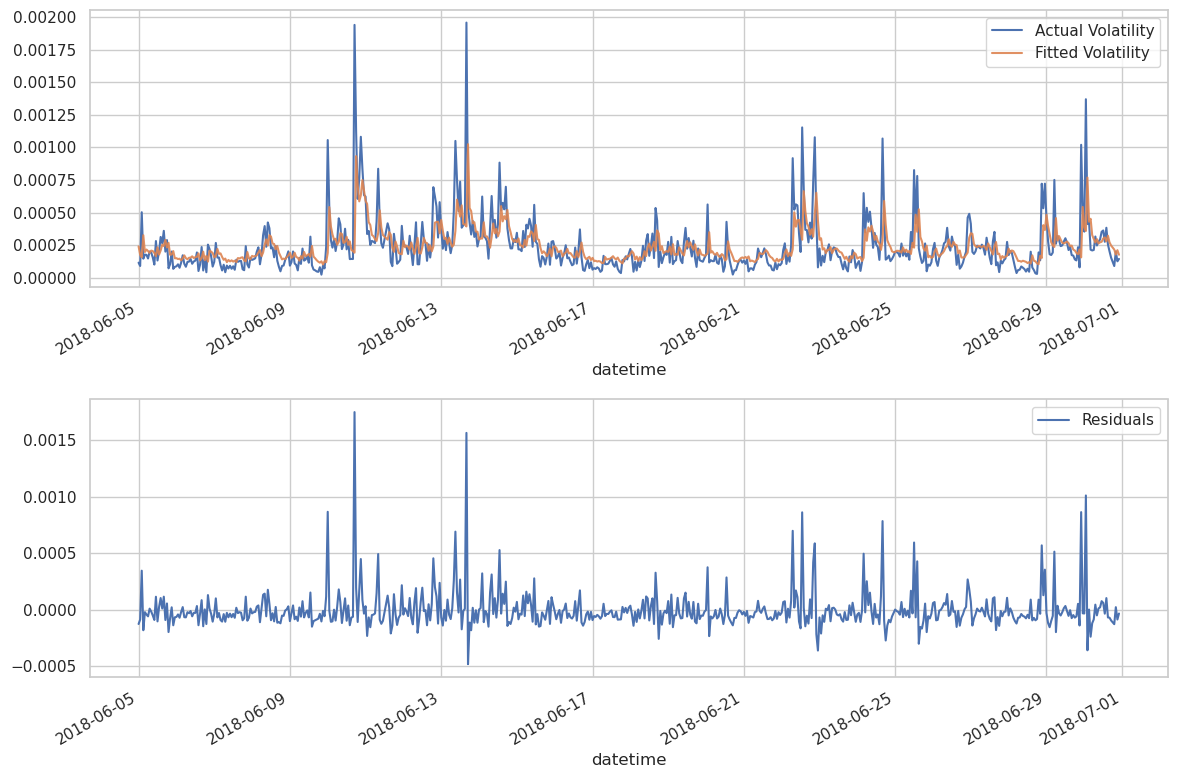

In [ ]:
# plot, add residuals in a subplot
arima_results_df = pd.DataFrame(init_training_vola)
arima_results_df["residuals"] = arima_results.resid
arima_results_df["fitted"] = arima_results.fittedvalues

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
arima_results_df["vol"].plot(ax=ax[0], label="Actual Volatility")
arima_results_df["fitted"].plot(ax=ax[0], label="Fitted Volatility", alpha=0.9)
ax[0].legend()
arima_results_df["residuals"].plot(ax=ax[1], label="Residuals")
plt.tight_layout()
ax[1].legend()
plt.show()


### Online ARIMA

In [ ]:
# wrapper around arima
class OnlineARMA():
    """
    ARMA volatility predictor (we know already that vola is stationary). 
    Given the past volatility, predict the next one using ARIMA model.
    """
    def __init__(
        self,
        p: int,
        q: int,
        *args,
        **kwargs,
    ):
        self.p = p
        self.q = q
        self.arima_order = (p, 0, q)
        self.endog = None
        self.model = None
        self.results = None
        self.residuals = None

    def fit(self, endog: np.ndarray = None):
        """
        Use this method to fit daily. 

        endog: numpy array of shape (n, 1) or (n, )
            data used to fit the model. 
        """
        # append_endog_data: if True, append the new data to the existing data.
        # if self.endog is None:
        #     self.endog = endog
        # elif append_endog_data:
        #     self.endog = np.append(self.endog, endog) 
        # else:
        #     self.endog = endog

        self.endog = endog

        self.model = ARIMA(endog=self.endog, order=self.arima_order)

        if self.results is None:
            self.results = self.model.fit(method_kwargs={'maxiter':1000})
            self.residuals = self.results.resid
        else:
            self.results = self.model.fit(
                method_kwargs={'maxiter':1000},
                start_params=self.results.params, # should help with convergence
            )
            self.residuals = self.results.resid

    def forecast(self, steps: int = 1):
        """
        Forecast the next steps volatility.
        """
        if self.results is None:
            raise ValueError("Model not fitted yet. Please fit the model first.")
        return self.results.forecast(steps=steps)

    def update(self, new_data: np.ndarray):
        """
        Update the model with new data.
        new_data: numpy array of new observations. The new data is not used to refit the model, but
        to update the fitted ARIMA ... 
        """
        self.endog = np.append(self.endog, new_data)
        self.results = self.results.apply(self.endog, refit=False)
        self.residuals = self.results.resid


In [ ]:
online_arima = OnlineARMA(
    p=best_p,
    q=best_q,
)

In [ ]:
# initial fit
online_arima.fit(
    endog=init_training_vola.lagged_vola.values,
)
online_arima.results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  620
Model:                 ARIMA(1, 0, 2)   Log Likelihood                4477.057
Date:                Mon, 12 May 2025   AIC                          -8944.114
Time:                        14:22:05   BIC                          -8921.966
Sample:                             0   HQIC                         -8935.505
                                - 620                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   3.64e-05      6.601      0.000       0.000       0.000
ar.L1          0.8769   3.37e-08    2.6e+07      0.000       0.877       0.877
ma.L1         -0.4609   2.18e-08  -2.11e+07      0.000      -0.461      -0.461
ma.L2         -0.1224   1.11e-08   -1.1e+07      0.000      -0.122      -0.122
sigma2      3.101e-08    6.7e-10     46.291      0.000    2.97e-08    3.23e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             25236.97
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             4.30
Prob(H) (two-sided):                  0.53   Kurtosis:                        33.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+23. Standard errors may be unstable.
"""

In [ ]:
test_days = pd.date_range(
    start=LAST_TRAINING_DATE,
    end=full_vola.index[-1],
    freq="d",
)

In [ ]:
test_days[0], test_days[-1]

(Timestamp('2018-07-01 00:00:00'), Timestamp('2018-09-30 00:00:00'))

In [ ]:
data = init_training_vola.lagged_vola.values

online_arima_results_df = full_vola.copy()
online_arima_results_df["prediction"] = None

for day in tqdm(test_days[1:]):
    batch = online_arima_results_df.loc[day:day+pd.Timedelta(hours=23), "lagged_vola"]  # from 00.00 to 23.00 of day

    if batch.shape[0] > 0:
        # fit the model using data before the batch
        online_arima.fit(
            endog=data,
        )
        data = np.append(data, batch.values)

        for t in batch.index:
            # update the model with the last available data point (lagged_vola, no look-ahead bias)
            online_arima.update(
                new_data=np.array(batch.loc[t]),
            )
            forecast = online_arima.forecast(steps=1)
            online_arima_results_df.loc[t, "prediction"] = forecast[0]

    else:
        # empty batch
        pass
    


  0%|          | 0/91 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 2/91 [00:00<00:12,  7.25it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  4%|▍         | 4/91 [00:01<00:38,  2.25it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 6/91 [00:03<01:00,  1.40it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/m

In [ ]:
online_arima_results_df

,vol,lagged_vola,prediction
datetime,,,
2018-06-05 00:00:00,0.000115,0.000143,None
2018-06-05 01:00:00,0.000090,0.000115,None
2018-06-05 02:00:00,0.000502,0.000090,None
2018-06-05 03:00:00,0.000146,0.000502,None
2018-06-05 04:00:00,0.000177,0.000146,None
...,...,...,...
2018-09-30 17:00:00,0.000025,0.000025,0.000067
2018-09-30 18:00:00,0.000014,0.000025,0.000067
2018-09-30 19:00:00,0.000024,0.000014,0.000062


In [ ]:
online_arima_results_df.dropna(inplace=True)

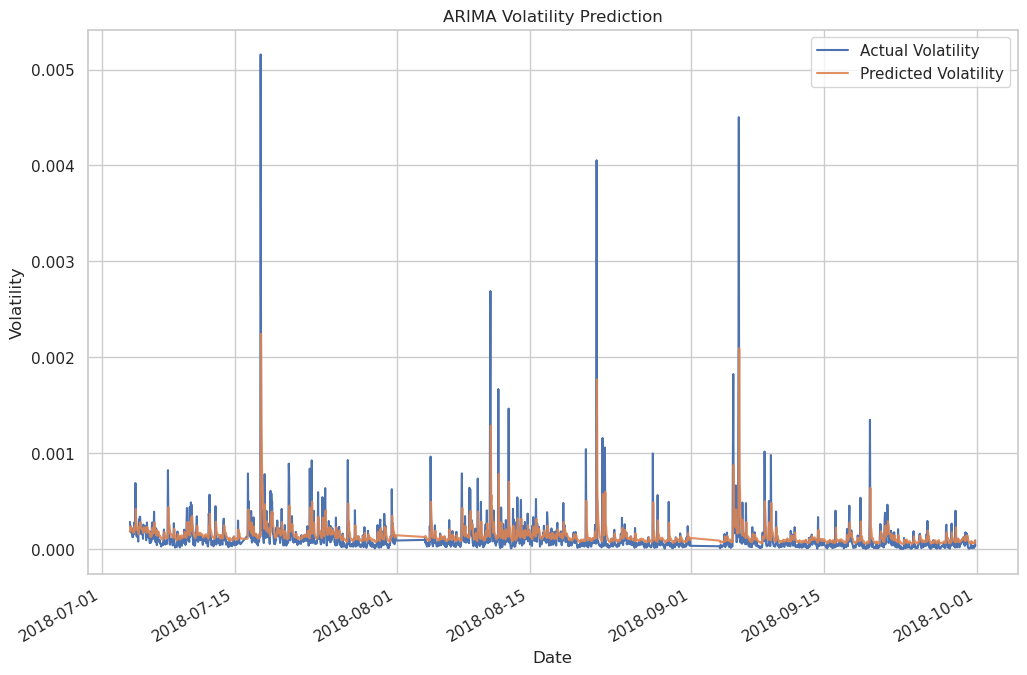

In [ ]:
plt.figure(figsize=(12, 8))
online_arima_results_df["vol"].plot(label="Actual Volatility")
online_arima_results_df["prediction"].plot(label="Predicted Volatility", alpha=0.9)
plt.title("ARIMA Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

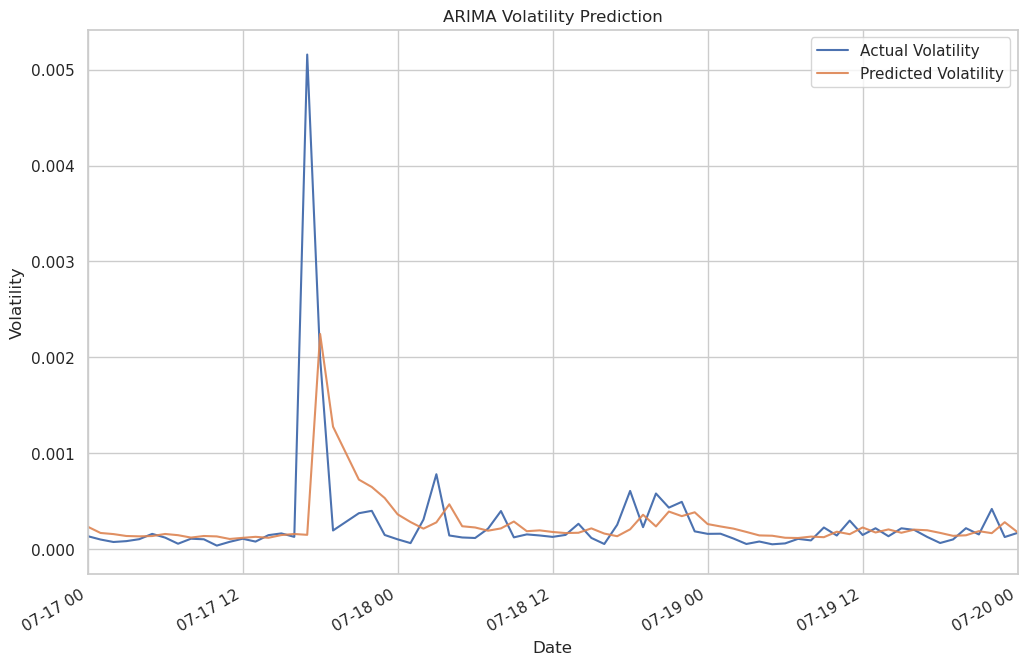

In [ ]:
plt.figure(figsize=(12, 8))
online_arima_results_df["vol"].plot(label="Actual Volatility")
online_arima_results_df["prediction"].plot(label="Predicted Volatility", alpha=0.9)
plt.title("ARIMA Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
# zoom in on the last 30 days
plt.xlim(
    datetime.strptime("2018-07-17 00:00:00", "%Y-%m-%d %H:%M:%S"),
    datetime.strptime("2018-07-20 00:00:00", "%Y-%m-%d %H:%M:%S"),
)
plt.legend()
plt.show()

<Axes: xlabel='datetime'>

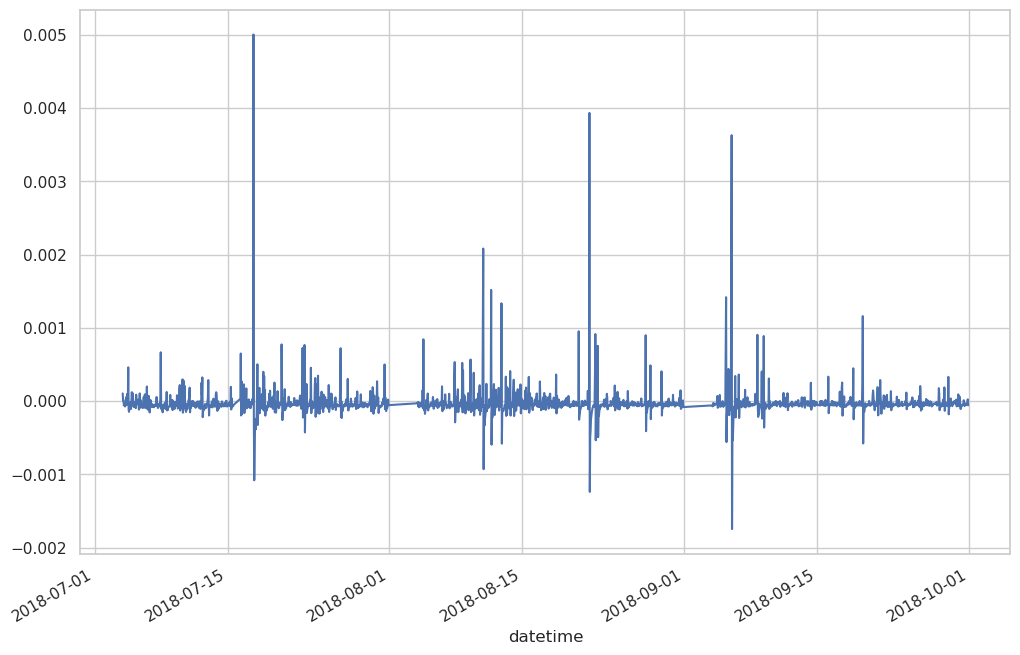

In [ ]:
# plot, add residuals in a subplot
online_arima_results_df["residuals"] = online_arima_results_df["vol"] - online_arima_results_df["prediction"]

plt.figure(figsize=(12, 8))
online_arima_results_df["residuals"].plot(label="Residuals (Online ARIMA)")

In [ ]:
# compute RMSE and MAE
rmse_arima = mse(
    online_arima_results_df["vol"].values,
    online_arima_results_df["prediction"].values,
) ** 0.5
mae_arima = mae(
    online_arima_results_df["vol"].values,
    online_arima_results_df["prediction"].values,
)
l2_disp = ((online_arima_results_df["prediction"] - online_arima_results_df["vol"])**2).std()
l1_disp = (online_arima_results_df["prediction"] - online_arima_results_df["vol"]).std()
print(f"RMSE: {rmse_arima}")
print(f"MAE: {mae_arima}")

RMSE: 0.0002341256521700913
MAE: 9.474099974913594e-05


TODO: analysis of the residuals

## GARCH(p,q)

In [9]:
from arch import arch_model

In [10]:
scale = 1.0

In [11]:
garch_init_training = full_data.select(["datetime", "vol",'ret']).filter(
    pl.col("datetime")<LAST_TRAINING_DATE
    ).with_columns(
        ret = pl.col("ret") * scale # garch optimization works better when scaled
    ).to_pandas().set_index("datetime").dropna()

In [12]:
garch_data = full_data.select(["datetime", "vol", 'ret', 'ret_t-1']).filter(
    ).with_columns(
        ret = pl.col("ret") * scale, # garch optimization works better when scaled
        lagged_ret = pl.col("ret_t-1") * scale # garch optimization works better when scaled
    ).to_pandas().set_index("datetime").dropna()

In [13]:
garch_model = arch_model(garch_init_training.ret.values, 
                        vol='Garch', 
                        p=1, 
                        o=0,
                        q=1, 
                        dist='Normal',
                        rescale=True)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3580.6370692099954
Iteration:      2,   Func. Count:     14,   Neg. LLF: 264665.92683164123
Iteration:      3,   Func. Count:     20,   Neg. LLF: 657.4740864010705
Iteration:      4,   Func. Count:     26,   Neg. LLF: 635.1843306017246
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2113.6489297074477
Iteration:      6,   Func. Count:     38,   Neg. LLF: 698.6058461684954
Iteration:      7,   Func. Count:     45,   Neg. LLF: 644.6235384598689
Iteration:      8,   Func. Count:     51,   Neg. LLF: 631.4009503175048
Iteration:      9,   Func. Count:     56,   Neg. LLF: 631.3936747117106
Iteration:     10,   Func. Count:     61,   Neg. LLF: 631.3851518215846
Iteration:     11,   Func. Count:     66,   Neg. LLF: 631.3837915156611
Iteration:     12,   Func. Count:     71,   Neg. LLF: 631.3835820454569
Iteration:     13,   Func. Count:     76,   Neg. LLF: 631.3835808002191
Iteration:     14,   Func. Count:     80,   Neg. LLF: 631.383

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -631.384
Distribution:                  Normal   AIC:                           1270.77
Method:            Maximum Likelihood   BIC:                           1288.49
                                        No. Observations:                  621
Date:                Fri, May 16 2025   Df Residuals:                      620
Time:                        21:27:26   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.9114e-03  3.635e-02      0.135      0.893 [-6.633e-02,7.615e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.2531  7.957e-02      3.181  1.467e-03    [9.716e-02,  0.409]
alpha[1]       0.9908      0.580      1.707  8.786e-02      [ -0.147,  2.129]
beta[1]    9.2241e-03  1.550e-02      0.595      0.552 [-2.115e-02,3.959e-02]
=============================================================================

Covariance estimator: robust
"""

**Note:** Non-significant $\beta$. Distribution of residuals is probably not normal, so let's test it.

In [16]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [17]:
jarque_bera(garch_results.resid)

(21184.502969855926, 0.0, 0.960051919804536, 31.548869569622518)

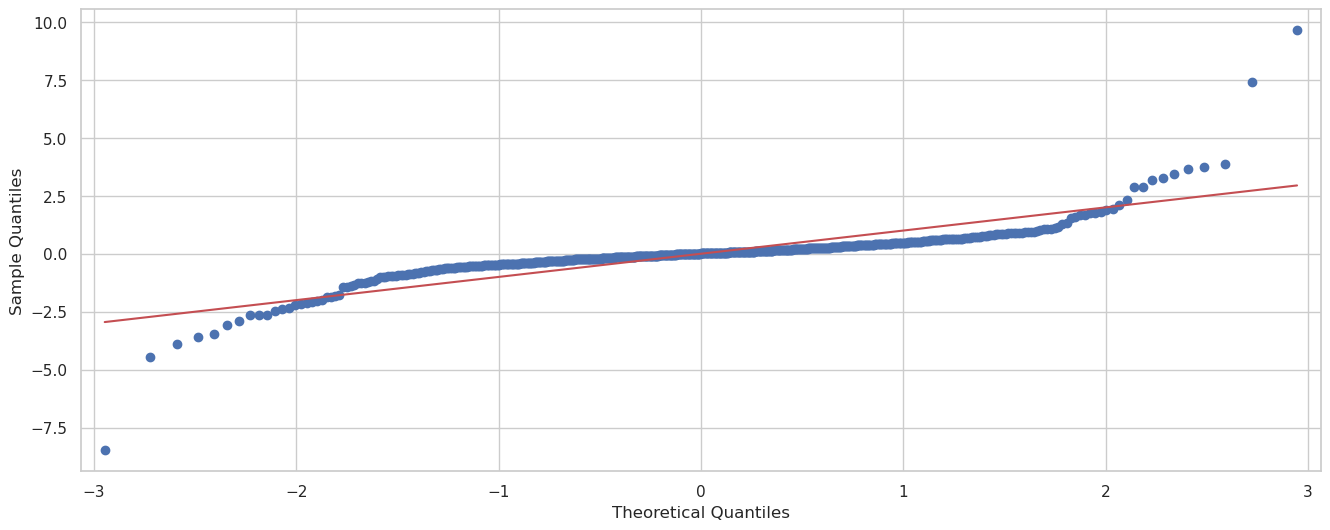

In [18]:
# qq plot of residuals
sm.qqplot(
    garch_results.resid,
    line="s",
    fit=True,
);

In [19]:
garch_results.__dict__.keys()

dict_keys(['_params', '_resid', '_is_pandas', '_model', '_datetime', '_dep_var', '_dep_name', '_names', '_loglikelihood', 'model', '_nobs', '_index', '_volatility', '_fit_indices', '_param_cov', '_r2', 'cov_type', '_optim_output', 'rsquared', 'nobs', 'rsquared_adj', 'loglikelihood', 'params', 'num_params', 'aic', 'bic', 'param_cov', 'std_err', 'tvalues', 'pvalues', 'convergence_flag'])

In [39]:
garch_results.conditional_volatility

array([0.72606251, 0.55623335, 0.52757032, 0.53538382, 1.20136787,
       0.5173906 , 0.6727291 , 0.85201945, 0.50970739, 0.57154337,
       0.8136704 , 0.65999029, 0.5084853 , 0.50777961, 0.50954771,
       0.58682303, 0.56859915, 2.17606382, 0.54505147, 0.80191268,
       0.51143233, 0.50576612, 0.51374657, 0.71064992, 0.69186276,
       0.51842735, 0.52327516, 0.65299967, 0.57355668, 0.5449294 ,
       0.52534625, 0.55865994, 0.59658037, 0.54331971, 0.51418813,
       0.61885836, 0.52896805, 0.50609531, 0.66124366, 0.56763933,
       0.51089253, 0.6028374 , 1.86040526, 0.54485007, 0.51013446,
       0.5213106 , 1.31294655, 0.84754797, 0.52118014, 0.51054059,
       0.9351416 , 0.51105272, 0.51845877, 0.53199425, 0.57064178,
       0.50903058, 0.51209015, 0.51142178, 0.52103143, 0.51514542,
       0.50727585, 0.50576353, 0.51269169, 0.5060763 , 0.53850508,
       0.50659585, 0.64196887, 0.64766374, 0.51095137, 0.50554148,
       0.66080936, 0.50710657, 0.51896642, 0.70340683, 0.51000

In [36]:
garch_model.volatility.__dict__.keys()

dict_keys(['_num_params', '_name', 'closed_form', '_normal', '_min_bootstrap_obs', '_start', '_stop', '_volatility_updater', 'p', 'o', 'q', 'power'])

In [28]:
garch_model._volatility

GARCH(p: 1, q: 1), id: 0x70cd729e0e30

In [41]:
garch_results.scale

100.0

In [46]:
garch_results.forecast(horizon=1).variance.values

array([[0.25711523]])

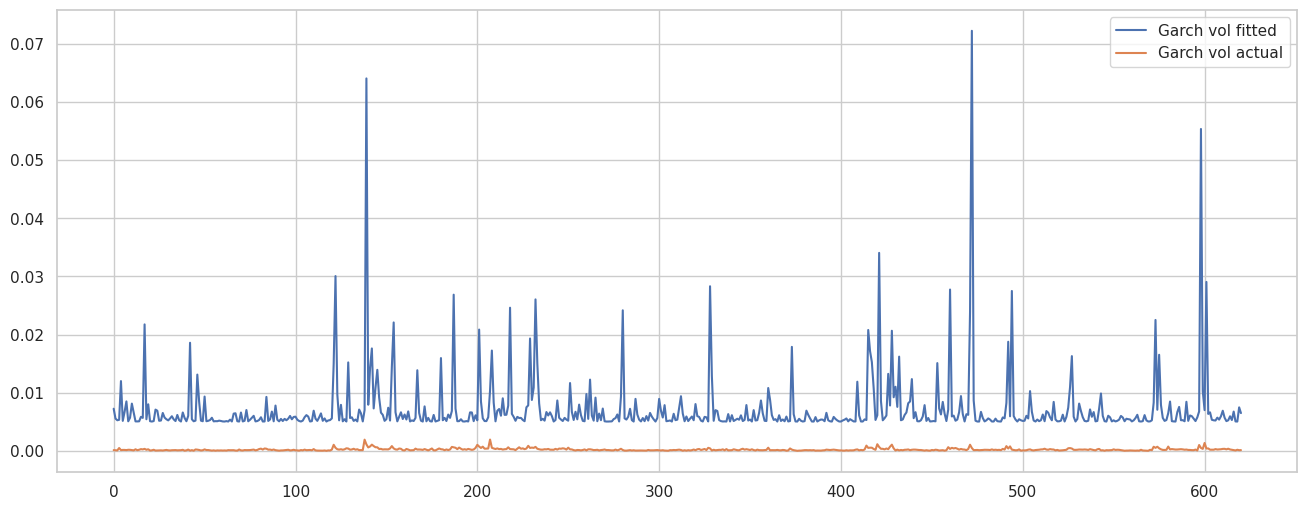

In [42]:
plt.plot(garch_results.conditional_volatility/garch_results.scale, label="Garch vol fitted")
plt.plot(garch_init_training.vol.values, label="Garch vol actual")
plt.legend()
plt.show()

In [24]:
garch_model._fit_y

array([-2.22918352e-01,  1.55176236e-01, -1.71869417e-01, -1.08989060e+00,
        4.07811067e-02, -4.40985313e-01,  6.92676260e-01,  5.38587796e-03,
       -2.63085969e-01,  6.45005393e-01, -4.17009256e-01, -3.31340799e-02,
       -4.37892082e-02, -5.98490026e-02, -2.94568688e-01,  2.65002252e-01,
        2.13114444e+00, -1.24175357e-02,  6.30070022e-01,  5.54046443e-02,
       -1.19408312e-02,  9.73753281e-02, -4.96891478e-01,  4.77105271e-01,
       -1.01629614e-01, -1.30743320e-01,  4.20083018e-01, -2.64529488e-01,
       -1.98037474e-01, -1.37678377e-01,  2.43606642e-01,  3.22486999e-01,
       -1.93001155e-01,  9.78678967e-02, -3.53736183e-01,  1.57832642e-01,
        2.61326673e-02,  4.33242571e-01, -2.51373206e-01, -6.56554074e-02,
        3.34918316e-01, -1.79355611e+00,  1.14186091e-01, -6.16805559e-02,
        1.33014276e-01,  1.22223861e+00,  6.78346457e-01, -1.04670548e-01,
       -6.64173515e-02,  7.95318186e-01,  3.10901771e-03, -1.10884851e-01,
        1.71310153e-01, -

Since the residuals are not normally distributed, we will use t-distribution.

In [19]:
garch_model = arch_model(garch_init_training.ret.values, 
                        vol='Garch', 
                        p=1, 
                        o=0,
                        q=1,
                        dist='studentst',
                        rescale=True)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 16536.42567228248
Iteration:      2,   Func. Count:     16,   Neg. LLF: 8558.277127433736
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1792.7933066399733
Iteration:      4,   Func. Count:     30,   Neg. LLF: 8515.57265952906
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1269.4558274269286
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1171.5290545682114
Iteration:      7,   Func. Count:     51,   Neg. LLF: 812.4799844624857
Iteration:      8,   Func. Count:     58,   Neg. LLF: 760.8930119087374
Iteration:      9,   Func. Count:     65,   Neg. LLF: 737.4872791723072
Iteration:     10,   Func. Count:     72,   Neg. LLF: 721.0340521059913
Iteration:     11,   Func. Count:     79,   Neg. LLF: 706.053330671796
Iteration:     12,   Func. Count:     86,   Neg. LLF: 695.8510272175831
Iteration:     13,   Func. Count:     93,   Neg. LLF: 577.0403731847207
Iteration:     14,   Func. Count:    100,   Neg. LLF: 420.87477

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -412.603
Distribution:      Standardized Student's t   AIC:                           835.206
Method:                  Maximum Likelihood   BIC:                           857.363
                                              No. Observations:                  621
Date:                      Fri, May 16 2025   Df Residuals:                      620
Time:                              20:33:32   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0148  1.262e-02     -1.176      0.240 [-3.958e-02,9.894e-03]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5244      0.171      3.058  2.230e-03    [  0.188,  0.861]
alpha[1]       0.9571      0.312      3.069  2.149e-03    [  0.346,  1.568]
beta[1]        0.0429  6.543e-02      0.656      0.512 [-8.531e-02,  0.171]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.2244  6.982e-02     31.861 9.382e-223 [  2.088,  2.361]
========================================================================

Covariance estimator: robust
"""

We will fit GARCH(1,1) with skewed t-distribution, to check if adding skewness improves the model. 
This is not very kosher way to decide whether to use skewed t-distribution or not - a better way would be to use formal tests.

In [20]:
frcst=garch_results.forecast(horizon=5)#.variance.values[-1, :][0] ** 0.5

In [50]:
frcst.variance.values[-1, :][0] ** 0.5

0.7453554788731356

In [75]:
2*(garch_results.conditional_volatility[-1] / garch_results.scale) ** 2

0.00014120513123846483

In [51]:
garch_init_training.vol.values[-1]

0.0001437820957512

In [40]:
garch_results.scale

100.0

In [ ]:
garch_results.conditional_volatility

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [43]:
garch_init_training.vol

datetime
2018-06-04 23:00:00    0.000143
2018-06-05 00:00:00    0.000115
2018-06-05 01:00:00    0.000090
2018-06-05 02:00:00    0.000502
2018-06-05 03:00:00    0.000146
                         ...   
2018-06-30 17:00:00    0.000154
2018-06-30 19:00:00    0.000089
2018-06-30 20:00:00    0.000202
2018-06-30 21:00:00    0.000126
2018-06-30 22:00:00    0.000144
Name: vol, Length: 621, dtype: float64

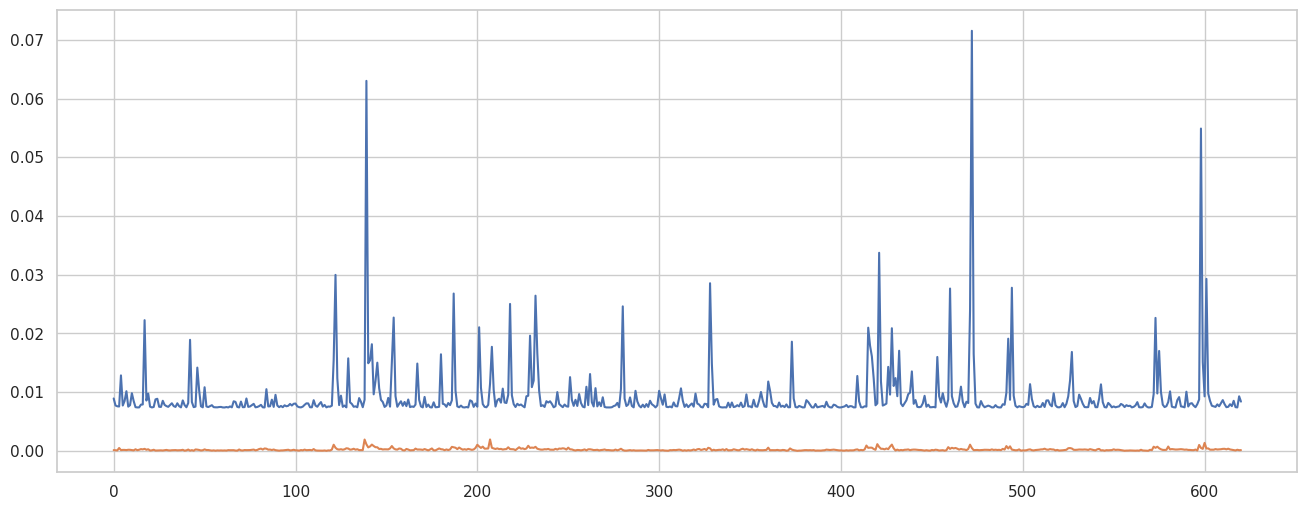

In [47]:
plt.plot(garch_results.conditional_volatility / garch_results.scale, label='GARCH(1,1) Volatility')
plt.plot(garch_init_training.vol.values, label='Real Volatility')

In [45]:
garch_init_training.vol.values

array([1.42600817e-04, 1.15285487e-04, 8.97325769e-05, 5.02444441e-04,
       1.45799526e-04, 1.76890660e-04, 1.75171997e-04, 1.47277527e-04,
       2.00911424e-04, 1.93258464e-04, 1.54886326e-04, 1.00790816e-04,
       2.81225915e-04, 1.31917667e-04, 2.02947729e-04, 3.12942130e-04,
       2.64472977e-04, 3.59718797e-04, 2.00114466e-04, 2.88533322e-04,
       7.16275945e-05, 1.03739996e-04, 2.00622040e-04, 6.76921819e-05,
       8.30828365e-05, 8.71056670e-05, 1.02464472e-04, 7.61379405e-05,
       1.15122488e-04, 1.72044783e-04, 1.06629530e-04, 8.36532616e-05,
       1.20878377e-04, 1.23278788e-04, 1.43590615e-04, 1.06683403e-04,
       1.24276082e-04, 1.30884507e-04, 1.93614784e-04, 5.12845022e-05,
       1.00789675e-04, 2.35287152e-04, 5.52981631e-05, 1.38251143e-04,
       4.16481032e-05, 2.53909950e-04, 2.20008844e-04, 1.66174254e-04,
       8.51001648e-05, 1.21507845e-04, 2.66736331e-04, 1.53794291e-04,
       1.54846530e-04, 9.61049219e-05, 5.53436338e-05, 9.94952293e-05,
      

In [29]:
frcst.variance.tail()

,h.1,h.2,h.3,h.4,h.5
620,0.555555,1.079943,1.604331,2.128718,2.653106


In [30]:
frcst.residual_variance.tail()

,h.1,h.2,h.3,h.4,h.5
620,0.555555,1.079943,1.604331,2.128718,2.653106


In [ ]:
# from statsmodels.stats.stattools import robust_skewness

In [ ]:
# robust_skewness(garch_results.resid)

In [ ]:
garch_model = arch_model(garch_init_training.ret.values, 
                        vol='Garch', 
                        p=1, 
                        o=0,
                        q=1,
                        # mean='Zero',
                        dist='skewstudent',
                        rescale=True)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 16340.521365491237
Iteration:      2,   Func. Count:     18,   Neg. LLF: 52071.49511434992
Iteration:      3,   Func. Count:     26,   Neg. LLF: 14492.147886060528
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1754.659979051917
Iteration:      5,   Func. Count:     42,   Neg. LLF: 9645.09514105351
Iteration:      6,   Func. Count:     50,   Neg. LLF: 1427.310685018789
Iteration:      7,   Func. Count:     58,   Neg. LLF: 767.805402897894
Iteration:      8,   Func. Count:     66,   Neg. LLF: 755.4961380824126
Iteration:      9,   Func. Count:     74,   Neg. LLF: 735.9608924382909
Iteration:     10,   Func. Count:     82,   Neg. LLF: 738.807432553343
Iteration:     11,   Func. Count:     90,   Neg. LLF: 715.8859591458533
Iteration:     12,   Func. Count:     98,   Neg. LLF: 741.5196295671348
Iteration:     13,   Func. Count:    106,   Neg. LLF: 419.8200360399889
Iteration:     14,   Func. Count:    114,   Neg. LLF: 417.9985504

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                                 y   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -412.303
Distribution:      Standardized Skew Student's t   AIC:                           836.606
Method:                       Maximum Likelihood   BIC:                           863.194
                                                   No. Observations:                  621
Date:                           Mon, May 12 2025   Df Residuals:                      620
Time:                                   14:24:34   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0249  1.774e-02     -1.405      0.160 [-5.970e-02,9.846e-03]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5327      0.175      3.042  2.352e-03    [  0.189,  0.876]
alpha[1]       0.9555      0.315      3.036  2.399e-03    [  0.339,  1.572]
beta[1]        0.0445  6.722e-02      0.662      0.508 [-8.725e-02,  0.176]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
eta            2.2210  6.928e-02     32.058 1.701e-225   [  2.085,  2.357]
lambda        -0.0350  4.287e-02     -0.817      0.414 [ -0.119,4.902e-02]
==========================================================================

Covariance estimator: robust
"""

**Note:** Non-significant skew parameter. We can work with symmetric t-distribution.

Choosing GARCH(1,1) instead of any other model is a bit arbitrary, and based on the common practice. We will check if a other choices of (p,q) are better. 

We will use AIC as a criterion for the model selection. Later we will do the same with GJB-GARCH, which is a modification of GARCH that allows for asymmetric response to shocks, and this will be done by setting parameter $o=1$.

In [ ]:
#Determines the p and q that minimizes the AIC
def find_p_q_garch(ts, max_p, max_q, o, dist="Normal"):
    p_q_table = pd.DataFrame(index=range(1, max_p + 1), columns=range(max_q + 1)) # p starts from 1
    for p in range(1, max_p + 1):
        for q in range(max_q + 1):
            model = arch_model(ts, vol='Garch', p=p, o=o, q=q, dist=dist,rescale=True)
            garch_results = model.fit()
            p_q_table.loc[p, q] = garch_results.aic


    # plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        p_q_table.astype(float),
        annot=True,
        fmt=".2f",
        #cmap="YlGnBu",
        cbar_kws={"label": "AIC"},
    )
    # add axis labels
    plt.title(f"AIC of GARCH(p,o={o},q) models")
    plt.xlabel("q")
    plt.ylabel("p")
    plt.show()

    return p_q_table

#Plots the residuals including their density
def plot_residuals(model):
    resids = model.resid[1:]
    fig, ax = plt.subplots(1,2)
    resids.plot(title='Residuals', ax=ax[0])
    resids.plot(title='Density', kind = 'kde', ax = ax[1])
    plt.show()

In [ ]:
p_max = 5
q_max = 5
o_fixed = 0

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17406.48346544515
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8528.875168892457
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1752.456462144243
Iteration:      4,   Func. Count:     27,   Neg. LLF: 991.0432014306842
Iteration:      5,   Func. Count:     33,   Neg. LLF: 817.7572935624237
Iteration:      6,   Func. Count:     39,   Neg. LLF: 781.7431779445285
Iteration:      7,   Func. Count:     45,   Neg. LLF: 761.6879883802436
Iteration:      8,   Func. Count:     51,   Neg. LLF: 747.1365820466297
Iteration:      9,   Func. Count:     57,   Neg. LLF: 734.411045861532
Iteration:     10,   Func. Count:     63,   Neg. LLF: 727.3450705219956
Iteration:     11,   Func. Count:     69,   Neg. LLF: 481.74985958836936
Iteration:     12,   Func. Count:     75,   Neg. LLF: 726.73561614255
Iteration:     13,   Func. Count:     81,   Neg. LLF: 422.28355615984094
Iteration:     14,   Func. Count:     87,   Neg. LLF: 418.0895261

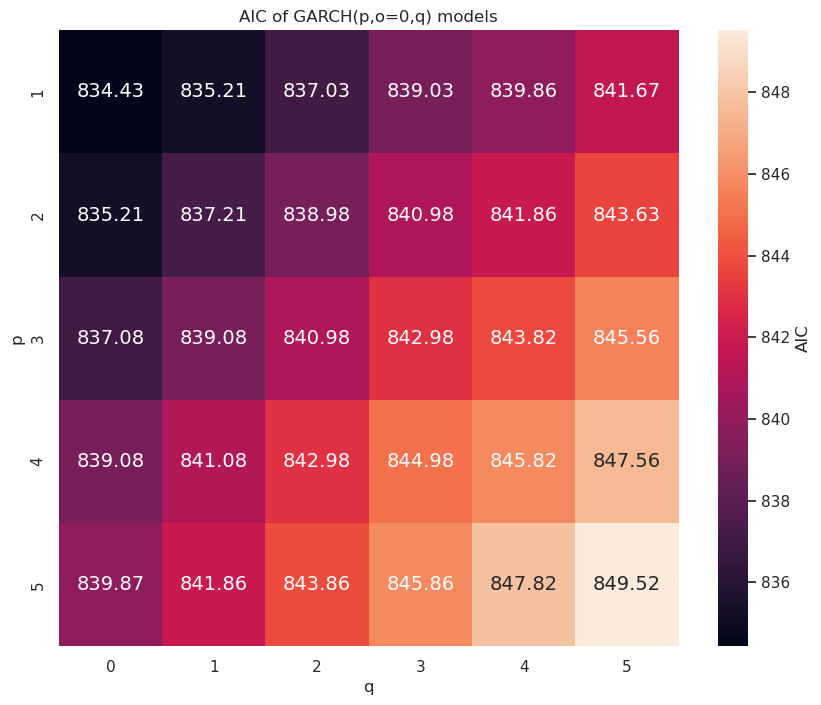

In [ ]:
aic_p_q = find_p_q_garch(
    garch_init_training.ret.values,
    max_p=p_max,
    max_q=q_max,
    o=o_fixed,
    dist="studentst",
)

In [ ]:
# find the best p, q
best_p, best_q = np.unravel_index(
    np.argmin(aic_p_q.values), aic_p_q.shape
)
best_p = best_p + 1 # add 1 because we start from 1
best_p = int(best_p)
best_q = int(best_q)
print(f"Best p: {best_p}, o={o_fixed},  Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

Best p: 1, o=0,  Best q: 0
Best AIC: 835.2149302778271


In [ ]:
garch_model = arch_model(garch_init_training.ret.values, vol='Garch', p=1, o=0, q=0, dist='studentst',rescale=True)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17406.48346544515
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8528.875168892457
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1752.456462144243
Iteration:      4,   Func. Count:     27,   Neg. LLF: 991.0432014306842
Iteration:      5,   Func. Count:     33,   Neg. LLF: 817.7572935624237
Iteration:      6,   Func. Count:     39,   Neg. LLF: 781.7431779445285
Iteration:      7,   Func. Count:     45,   Neg. LLF: 761.6879883802436
Iteration:      8,   Func. Count:     51,   Neg. LLF: 747.1365820466297
Iteration:      9,   Func. Count:     57,   Neg. LLF: 734.411045861532
Iteration:     10,   Func. Count:     63,   Neg. LLF: 727.3450705219956
Iteration:     11,   Func. Count:     69,   Neg. LLF: 481.74985958836936
Iteration:     12,   Func. Count:     75,   Neg. LLF: 726.73561614255
Iteration:     13,   Func. Count:     81,   Neg. LLF: 422.28355615984094
Iteration:     14,   Func. Count:     87,   Neg. LLF: 418.0895261

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -413.216
Distribution:      Standardized Student's t   AIC:                           834.432
Method:                  Maximum Likelihood   BIC:                           852.157
                                              No. Observations:                  621
Date:                      Mon, May 12 2025   Df Residuals:                      620
Time:                              14:24:38   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0155  1.259e-02     -1.230      0.219 [-4.016e-02,9.183e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5774      0.188      3.078  2.084e-03 [  0.210,  0.945]
alpha[1]       1.0000      0.320      3.124  1.786e-03 [  0.373,  1.627]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.2169  6.665e-02     33.260 1.464e-242 [  2.086,  2.348]
========================================================================

Covariance estimator: robust
"""

In [ ]:
garch_model = arch_model(garch_init_training.ret.values, vol='Garch', p=1, o=0, q=1, dist='studentst')
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 13547.658634134012
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1111202.577949895
Iteration:      3,   Func. Count:     39,   Neg. LLF: 5016.168239786415
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2035.6423421802147
Iteration:      5,   Func. Count:     54,   Neg. LLF: 1456.9369708144395
Iteration:      6,   Func. Count:     60,   Neg. LLF: 1573.8518587984872
Iteration:      7,   Func. Count:     67,   Neg. LLF: 1443.6444305463192
Iteration:      8,   Func. Count:     77,   Neg. LLF: 142742.8439683349
Iteration:      9,   Func. Count:     93,   Neg. LLF: 3789.3226910814956
Iteration:     10,   Func. Count:     99,   Neg. LLF: 7871.237634084613
Iteration:     11,   Func. Count:    107,   Neg. LLF: 3813.498240477169
Iteration:     12,   Func. Count:    116,   Neg. LLF: 25042.247121099754
Iteration:     13,   Func. Count:    132,   Neg. LLF: 11604.397595378674
Iteration:     14,   Func. Count:    138,   Neg. LLF: 39

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.68e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2141.12
Distribution:      Standardized Student's t   AIC:                          -4272.23
Method:                  Maximum Likelihood   BIC:                          -4250.08
                                              No. Observations:                  621
Date:                      Mon, May 12 2025   Df Residuals:                      620
Time:                              14:24:38   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.1316e-04  1.457e-04      2.149  3.163e-02 [2.755e-05,5.988e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.6451e-04  2.581e-05     21.875 4.506e-106 [5.139e-04,6.151e-04]
alpha[1]       0.8669      0.574      1.511      0.131     [ -0.257,  1.991]
beta[1]        0.1331  3.773e-02      3.526  4.216e-04   [5.910e-02,  0.207]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.2773  9.245e-03    246.320      0.000 [  2.259,  2.295]
========================================================================

Covariance estimator: robust
"""

**Note** the difference in AIC between GARCH(1,0) and GARCH(1,1) relativly small, and $\beta_1$ in GARCH(1,1) is small and non significant. So we will use GARCH(1,1) as a benchmark, as it is the common choice and the version of GARCH used in the original paper we are reproducing here.

### Online GARCH

In [117]:
# wrapper around arima
class OnlineGARCH():
    """
    GARCH volatility predictor (we know already that vola is stationary). 
    Given the past volatility, predict the next one using GARCH model.
    """
    def __init__(
        self,
        p: int,
        o: int,
        q: int,
        dist: str = 'studentst',
        *args,
        **kwargs,
    ):
        self.p = p
        self.o = o
        self.q = q
        self.arima_order = (p, o, q)
        self.dist = dist
        self.endog = None
        self.model = None
        self.results = None
        #self.residuals = None

    def fit(self, endog: np.ndarray = None):
        """
        Use this method to fit daily. 

        endog: numpy array of shape (n, 1) or (n, )
            data used to fit the model. 
        """
        self.endog = endog

        self.model = arch_model(
            self.endog,
            vol='Garch',
            p=self.p,
            o=self.o,
            q=self.q,
            dist=self.dist,
            rescale=True,
        )
        self.results = self.model.fit(disp="off")
        

    def forecast(self, steps: int = 1):
        """
        Forecast the next steps volatility.
        """
        if self.results is None:
            raise ValueError("Model not fitted yet. Please fit the model first.")
        #return self.results.forecast().variance.values[0][0]
        return (self.results.conditional_volatility[-1])

    def update(self, new_data: np.ndarray):
        """
        Update the model with new data.
        new_data: numpy array of new observations. The new data is not used to refit the model, but
        to update the fitted ARIMA ... 
        """
        self.endog = np.append(self.endog, new_data)
        # TODO: do not refit, but use the existing model, only update the data
        self.model = arch_model(
            self.endog,
            vol='Garch',
            p=self.p,
            o=self.o,
            q=self.q,
            dist=self.dist,
            rescale=True,
        )
        self.results = self.model.fit(disp="off")
        # self.results = self.results.apply(self.endog, refit=False)
        self.residuals = self.results.resid


In [ ]:
online_garch = OnlineGARCH(
    p=1,
    o=0,
    q=1,
    dist='Normal',
)

In [119]:
garch_init_training

,vol,ret
datetime,,
2018-06-04 23:00:00,0.000143,-0.002229
2018-06-05 00:00:00,0.000115,0.001552
2018-06-05 01:00:00,0.000090,-0.001719
2018-06-05 02:00:00,0.000502,-0.010899
2018-06-05 03:00:00,0.000146,0.000408
...,...,...
2018-06-30 17:00:00,0.000154,0.000137
2018-06-30 19:00:00,0.000089,0.000182
2018-06-30 20:00:00,0.000202,0.005612


In [120]:
# initial fit
online_garch.fit(
    endog=garch_init_training.ret.values,
)
online_garch.results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -412.603
Distribution:      Standardized Student's t   AIC:                           835.206
Method:                  Maximum Likelihood   BIC:                           857.363
                                              No. Observations:                  621
Date:                      Fri, May 16 2025   Df Residuals:                      620
Time:                              21:08:53   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0148  1.262e-02     -1.176      0.240 [-3.958e-02,9.894e-03]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5244      0.171      3.058  2.230e-03    [  0.188,  0.861]
alpha[1]       0.9571      0.312      3.069  2.149e-03    [  0.346,  1.568]
beta[1]        0.0429  6.543e-02      0.656      0.512 [-8.531e-02,  0.171]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.2244  6.982e-02     31.861 9.382e-223 [  2.088,  2.361]
========================================================================

Covariance estimator: robust
"""

In [121]:
test_days = pd.date_range(
    start=LAST_TRAINING_DATE,
    end=full_vola.index[-1],
    freq="d",
)
test_days[0], test_days[-1]

(Timestamp('2018-07-01 00:00:00'), Timestamp('2018-09-30 00:00:00'))

In [122]:
data = garch_data.lagged_ret.values

online_garch_results_df = garch_data.copy()
online_garch_results_df["prediction"] = None

for day in tqdm(test_days[1:]):
    batch = online_garch_results_df.loc[day:day+pd.Timedelta(hours=23), "lagged_ret"]  # from 00.00 to 23.00 of day

    if batch.shape[0] > 0:
        # fit the model using data before the batch
        online_garch.fit(
            endog=data,
        )
        data = np.append(data, batch.values)

        for t in batch.index:
            online_garch.update(
                new_data=np.array(batch.loc[t]),
            )
            # update the model with the last available data point (lagged_vola, no look-ahead bias)
            online_garch_results_df.loc[t, "prediction"] = online_garch.forecast()

    else:
        # empty batch
        pass
    


  0%|          | 0/91 [00:00<?, ?it/s]

100%|██████████| 91/91 [02:34<00:00,  1.70s/it]


In [109]:
online_garch_results_df.dropna(inplace=True)

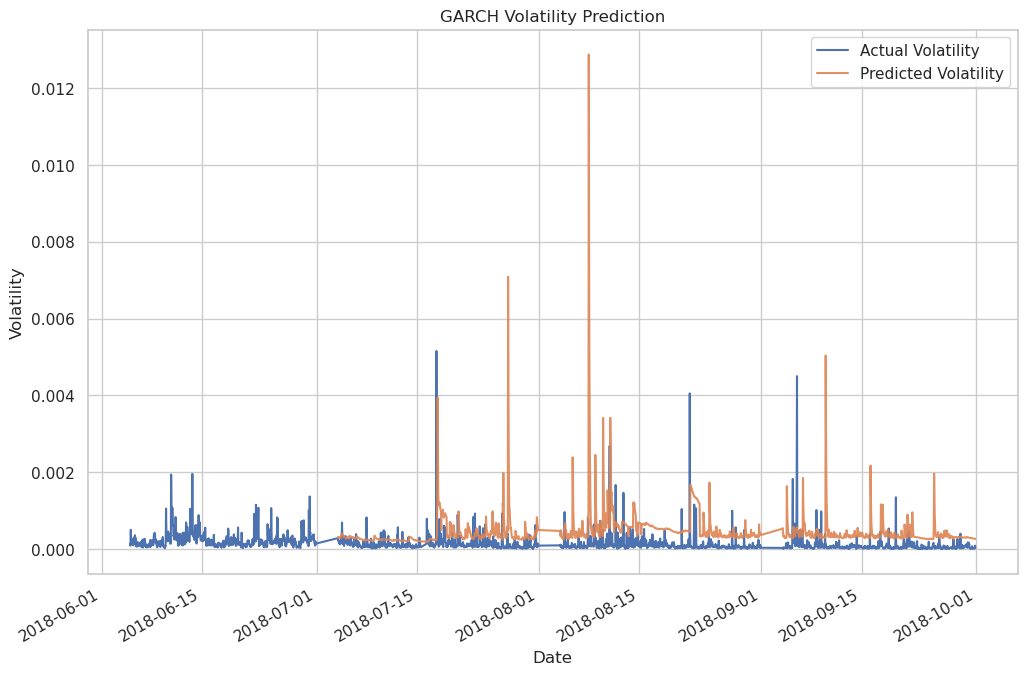

In [126]:
plt.figure(figsize=(12, 8))
online_garch_results_df["vol"].plot(label="Actual Volatility")
((online_garch_results_df["prediction"]/100)**2).plot(label="Predicted Volatility", alpha=0.9)
plt.title("GARCH Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

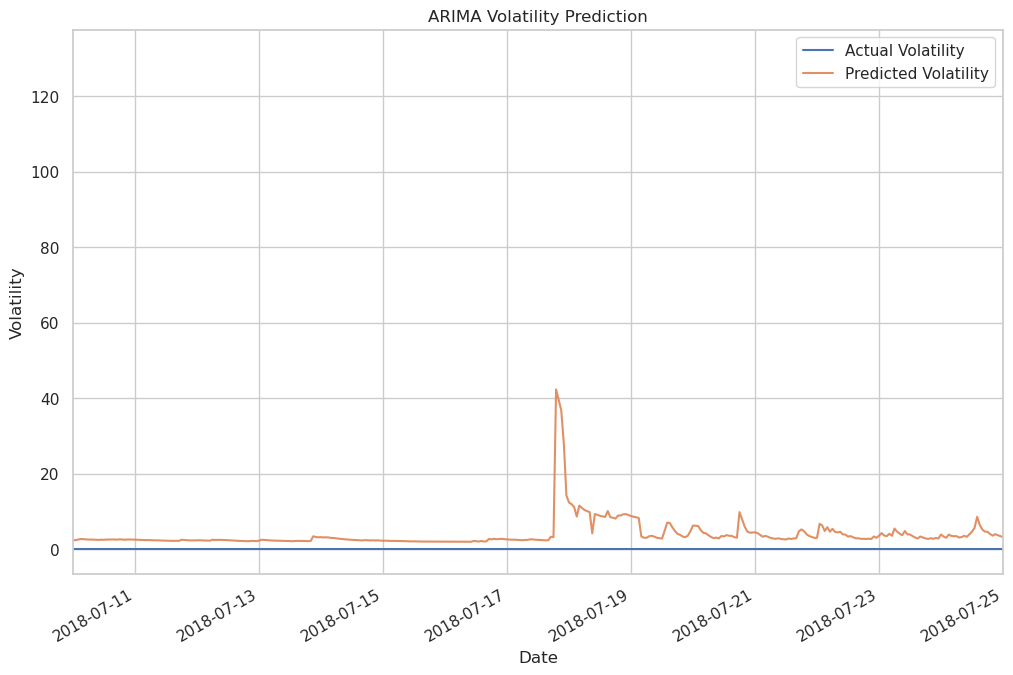

In [111]:
plt.figure(figsize=(12, 8))
online_garch_results_df["vol"].plot(label="Actual Volatility")
online_garch_results_df["prediction"].plot(label="Predicted Volatility", alpha=0.9)
plt.title("ARIMA Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
# zoom in on the last 30 days
plt.xlim(
    datetime.strptime("2018-07-10 00:00:00", "%Y-%m-%d %H:%M:%S"),
    datetime.strptime("2018-07-25 00:00:00", "%Y-%m-%d %H:%M:%S"),
)
plt.legend()
plt.show()

<Axes: xlabel='datetime'>

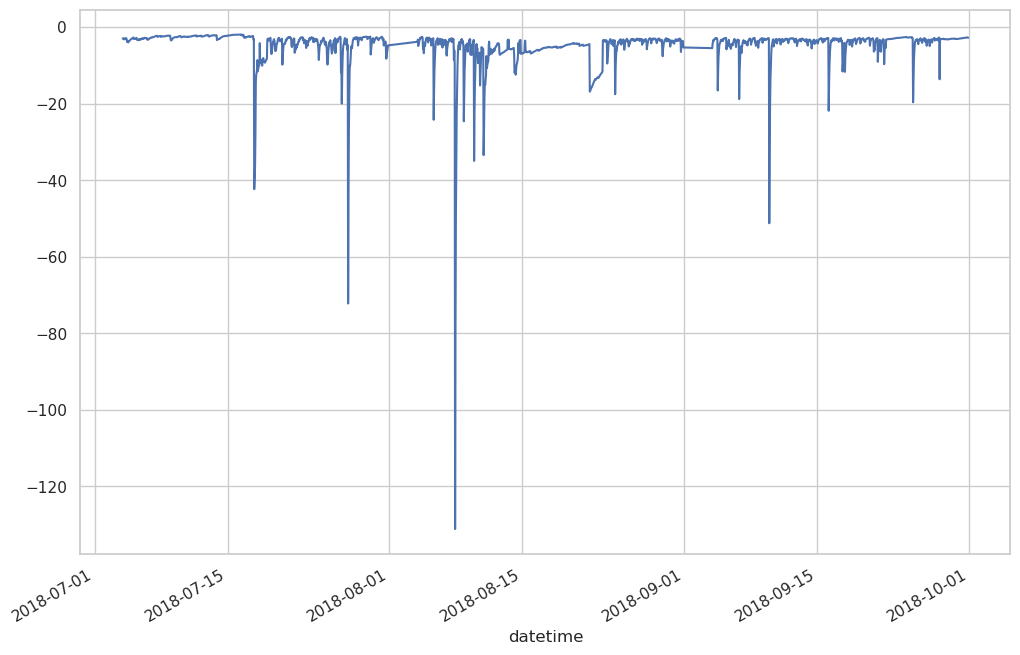

In [112]:
# plot, add residuals in a subplot
online_garch_results_df["residuals"] = online_garch_results_df["vol"] - online_garch_results_df["prediction"]

plt.figure(figsize=(12, 8))
online_garch_results_df["residuals"].plot(label="Residuals (Online ARIMA)")

In [113]:
# compute RMSE and MAE
rmse_arima = mse(
    online_garch_results_df["vol"].values,
    online_garch_results_df["prediction"].values,
) ** 0.5
mae_arima = mae(
    online_garch_results_df["vol"].values,
    online_garch_results_df["prediction"].values,
)
l2_disp = ((online_garch_results_df["prediction"] - online_garch_results_df["vol"])**2).std()
l1_disp = (online_garch_results_df["prediction"] - online_garch_results_df["vol"]).std()
print(f"RMSE: {rmse_arima}")
print(f"MAE: {mae_arima}")

RMSE: 6.994997637293218
MAE: 4.6692617862914165


In [114]:
# find the best p, q
best_p, best_q = np.unravel_index(
    np.argmin(aic_p_q.values), aic_p_q.shape
)
best_p = best_p + 1 # add 1 because we start from 1
print(f"Best p: {best_p}, o=0,  Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

NameError: name 'aic_p_q' is not defined

In [ ]:
garch_model = arch_model(garch_init_training.ret.values, vol='Garch', p=1, o=0, q=1, dist='Normal')
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3706502141.475864
Iteration:      2,   Func. Count:     18,   Neg. LLF: 191939.09641280555
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1752199.4671969633
Iteration:      4,   Func. Count:     40,   Neg. LLF: -2194.271751384541
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2194.2717518294585
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 4


/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.68e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2194.27
Distribution:                  Normal   AIC:                          -4380.54
Method:            Maximum Likelihood   BIC:                          -4362.82
                                        No. Observations:                  621
Date:                Mon, May 12 2025   Df Residuals:                      620
Time:                        14:27:07   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -8.0618e-05  2.734e-04     -0.295      0.768 [-6.165e-04,4.552e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.8401e-05  6.150e-07     46.182      0.000 [2.720e-05,2.961e-05]
alpha[1]       0.2000      0.185      1.080      0.280     [ -0.163,  0.563]
beta[1]        0.3000      0.196      1.529      0.126  [-8.463e-02,  0.685]
============================================================================

Covariance estimator: robust
"""

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3567.5561900411844
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1300.834449695943
Iteration:      3,   Func. Count:     24,   Neg. LLF: 689.4186871352963
Iteration:      4,   Func. Count:     30,   Neg. LLF: 628.1770782395981
Iteration:      5,   Func. Count:     35,   Neg. LLF: 627.5194027958407
Iteration:      6,   Func. Count:     40,   Neg. LLF: 626.7306428254284
Iteration:      7,   Func. Count:     45,   Neg. LLF: 626.6736853251775
Iteration:      8,   Func. Count:     50,   Neg. LLF: 626.6695503187204
Iteration:      9,   Func. Count:     55,   Neg. LLF: 626.6694864573133
Iteration:     10,   Func. Count:     60,   Neg. LLF: 626.6694841069018
Iteration:     11,   Func. Count:     64,   Neg. LLF: 626.6694839817736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 626.6694841069018
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 1

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    126,   Neg. LLF: 616.6059017019919
Iteration:      9,   Func. Count:    140,   Neg. LLF: 626.6766057759074
Iteration:     10,   Func. Count:    155,   Neg. LLF: 273157445.54169685
Iteration:     11,   Func. Count:    170,   Neg. LLF: 619.4437476685171
Iteration:     12,   Func. Count:    185,   Neg. LLF: 610.9036853699508
Iteration:     13,   Func. Count:    199,   Neg. LLF: 610.129044223024
Iteration:     14,   Func. Count:    213,   Neg. LLF: 609.9941871857741
Iteration:     15,   Func. Count:    227,   Neg. LLF: 609.9648049119385
Iteration:     16,   Func. Count:    241,   Neg. LLF: 609.9596477747882
Iteration:     17,   Func. Count:    255,   Neg. LLF: 609.9594152992172
Iteration:     18,   Func. Count:    269,   Neg. LLF: 609.9593762316683
Iteration:     19,   Func. Count:    283,   Neg. LLF: 609.9593756194782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 609.9593756194782
            Iterations: 19
 

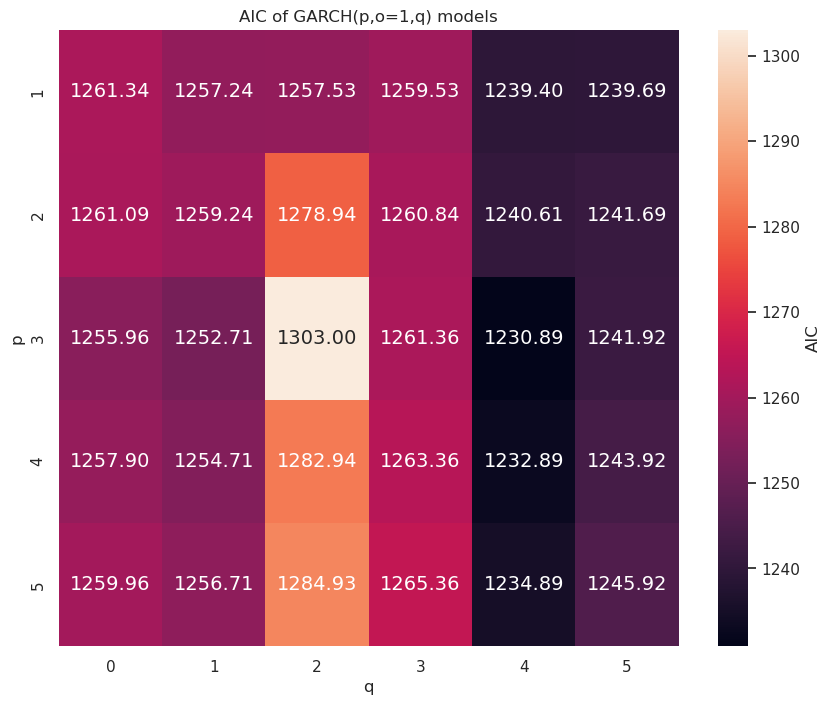

In [ ]:
# make p, q mash
p_max = 5
q_max = 5
aic_p_q = find_p_q_garch(
    garch_init_training.ret.values,
    max_p=p_max,
    max_q=q_max,
    o=1,
)

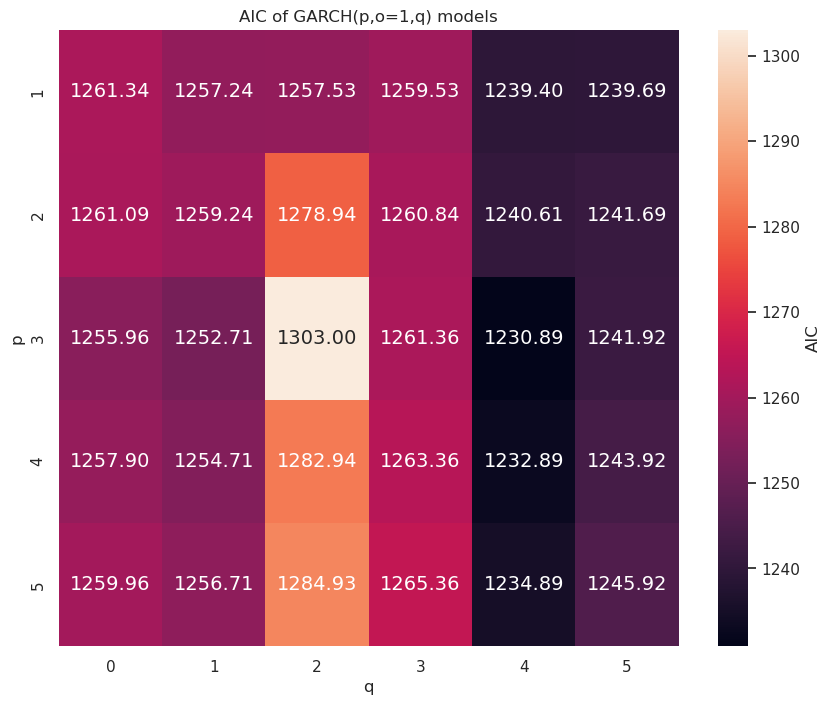

In [ ]:
# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    aic_p_q.astype(float),
    annot=True,
    fmt=".2f",
    #cmap="YlGnBu",
    cbar_kws={"label": "AIC"},
)
# add axis labels
plt.title("AIC of GARCH(p,o=1,q) models")
plt.xlabel("q")
plt.ylabel("p")
plt.show()

In [ ]:
# find the best p, q
best_p, best_q = np.unravel_index(
    np.argmin(aic_p_q.values), aic_p_q.shape
)
best_p = best_p + 1 # add 1 because we start from 1
print(f"Best p: {best_p}, o=1,  Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

Best p: 3, o=1,  Best q: 4
Best AIC: 1232.8946323310633


In [ ]:
garch_model = arch_model(garch_init_training.ret.values, vol='Garch', p=1, o=1, q=1, dist='Normal')
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 160071475537.10605
Iteration:      2,   Func. Count:     20,   Neg. LLF: 75146.65524223025
Iteration:      3,   Func. Count:     30,   Neg. LLF: 36286439.95524335
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2209.81034368785
            Iterations: 4
            Function evaluations: 38
            Gradient evaluations: 3


/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.68e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                2209.81
Distribution:                  Normal   AIC:                          -4409.62
Method:            Maximum Likelihood   BIC:                          -4387.46
                                        No. Observations:                  621
Date:                Mon, May 12 2025   Df Residuals:                      620
Time:                        14:27:10   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -4.5687e-05  2.886e-04     -0.158      0.874 [-6.113e-04,5.199e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.8562e-05  1.078e-06     26.487 1.371e-154 [2.645e-05,3.068e-05]
alpha[1]       0.1999      0.359      0.557      0.577     [ -0.503,  0.903]
gamma[1]       0.2005      0.327      0.613      0.540     [ -0.441,  0.842]
beta[1]        0.1999      0.185      1.078      0.281     [ -0.163,  0.563]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# find the best p, q
best_p, best_q = np.unravel_index(
    np.argmin(aic_p_q.values), aic_p_q.shape
)
best_p = best_p + 1 # add 1 because we start from 1
print(f"Best p: {best_p}, o=1,  Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

Best p: 3, o=1,  Best q: 4
Best AIC: 1232.8946323310633


## Beta-t-EGARCH

In [ ]:
p_max = 5
q_max = 5
o_fixed = 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 3007.6381828498716
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5449.262539752885
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8530.116688785372
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1284.1782612586887
Iteration:      5,   Func. Count:     37,   Neg. LLF: 831.550610118828
Iteration:      6,   Func. Count:     44,   Neg. LLF: 840.311886517958
Iteration:      7,   Func. Count:     51,   Neg. LLF: 796.7276508606134
Iteration:      8,   Func. Count:     58,   Neg. LLF: 746.4470820611424
Iteration:      9,   Func. Count:     65,   Neg. LLF: 726.3170609039116
Iteration:     10,   Func. Count:     72,   Neg. LLF: 714.3231763325509
Iteration:     11,   Func. Count:     79,   Neg. LLF: 710.6751654195735
Iteration:     12,   Func. Count:     86,   Neg. LLF: 706.20402184889
Iteration:     13,   Func. Count:     93,   Neg. LLF: 434.3984929555437
Iteration:     14,   Func. Count:    100,   Neg. LLF: 411.27197741

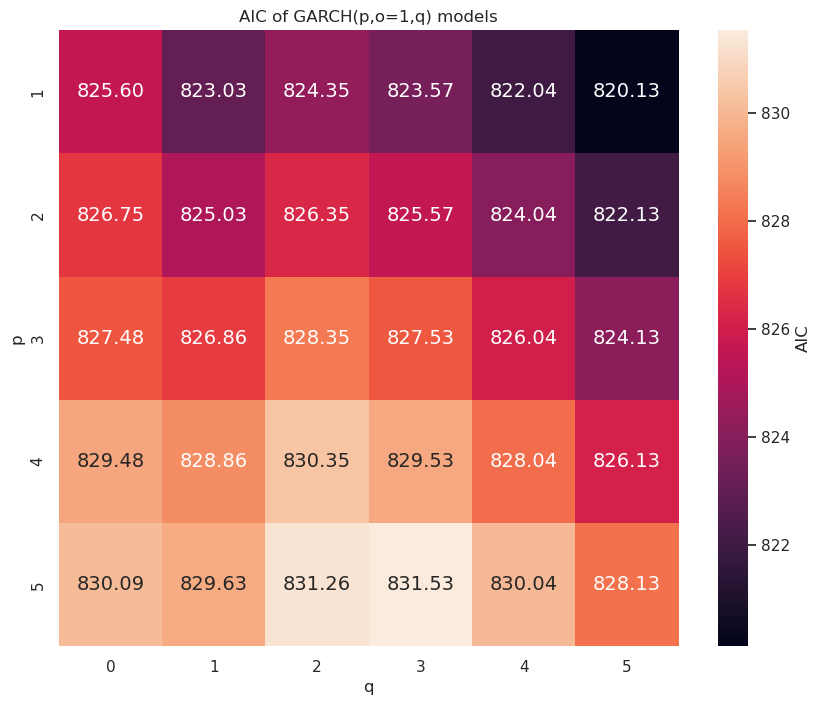

In [ ]:
aic_p_q = find_p_q_garch(
    garch_init_training.ret.values,
    max_p=p_max,
    max_q=q_max,
    o=o_fixed,
    dist="studentst",
)

In [ ]:
# find the best p, q
best_p, best_q = np.unravel_index(
    np.argmin(aic_p_q.values), aic_p_q.shape
)
best_p = best_p + 1 # add 1 because we start from 1
best_p = int(best_p)
best_q = int(best_q)
print(f"Best p: {best_p}, o={o_fixed},  Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

Best p: 1, o=1,  Best q: 5
Best AIC: 822.1319163954574


In [ ]:
garch_model = arch_model(garch_init_training.ret.values, vol='Garch', p=best_p, o=o_fixed, q=best_q, dist='studentst')
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:     12,   Neg. LLF: 17497.352622054917
Iteration:      2,   Func. Count:     33,   Neg. LLF: 10598.43160694576
Iteration:      3,   Func. Count:     49,   Neg. LLF: 88935.355040722
Iteration:      4,   Func. Count:     61,   Neg. LLF: 18575.283495233423
Iteration:      5,   Func. Count:     74,   Neg. LLF: 2655.650897711026
Iteration:      6,   Func. Count:     87,   Neg. LLF: 5435.100223165729
Iteration:      7,   Func. Count:     99,   Neg. LLF: 55050.14238027171
Iteration:      8,   Func. Count:    116,   Neg. LLF: 168462.0688004789
Iteration:      9,   Func. Count:    137,   Neg. LLF: 4517.857302514347
Iteration:     10,   Func. Count:    151,   Neg. LLF: 29968.715238501623
Iteration:     11,   Func. Count:    163,   Neg. LLF: 8417.37678127627
Iteration:     12,   Func. Count:    176,   Neg. LLF: 17960.39282888141
Iteration:     13,   Func. Count:    197,   Neg. LLF: 1920.1920502369117
Iteration:     14,   Func. Count:    208,   Neg. LLF: 34823.990

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.68e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3326.00
Distribution:      Standardized Student's t   AIC:                           6672.01
Method:                  Maximum Likelihood   BIC:                           6716.32
                                              No. Observations:                  621
Date:                      Mon, May 12 2025   Df Residuals:                      620
Time:                              14:27:14   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           -11.6373      4.122     -2.823  4.756e-03 [-19.717, -3.558]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.4060e-08  4.529e-05  1.415e-03      0.999 [-8.870e-05,8.882e-05]
alpha[1]       0.9815      1.298      0.756      0.450      [ -1.563,  3.526]
gamma[1]      -0.9468      2.355     -0.402      0.688      [ -5.562,  3.668]
beta[1]        0.5259      2.222      0.237      0.813      [ -3.829,  4.880]
beta[2]    3.4323e-04      3.564  9.630e-05      1.000      [ -6.985,  6.986]
beta[3]    3.3903e-04      4.200  8.073e-05      1.000      [ -8.231,  8.232]
beta[4]    3.3501e-04      4.649  7.206e-05      1.000      [ -9.112,  9.112]
beta[5]    3.3144e-04      8.710  3.805e-05      1.000      [-17.071, 17.071]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu            37.9815     64.759      0.587      0.558 [-88.944,1.649e+02]
==========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

## HAR

In [ ]:
from arch.univariate import HARX


In [ ]:
full_data.select(["datetime", "vol"]).filter(
    pl.col("datetime")<LAST_TRAINING_DATE
    ).with_columns(
        lagge_vol = pl.col("vol")
    ).to_pandas().set_index("datetime").dropna()

,vol,lagge_vol
datetime,,
2018-06-04 23:00:00,0.000143,0.000143
2018-06-05 00:00:00,0.000115,0.000115
2018-06-05 01:00:00,0.000090,0.000090
2018-06-05 02:00:00,0.000502,0.000502
2018-06-05 03:00:00,0.000146,0.000146
...,...,...
2018-06-30 17:00:00,0.000154,0.000154
2018-06-30 19:00:00,0.000089,0.000089
2018-06-30 20:00:00,0.000202,0.000202


In [ ]:
full_data

datetime,vol,ret,ret_t-1,ret_t-2,ret_t-3,ret_t-4,ret_t-5,ret_t-6,ret_t-7,ret_t-8,ret_t-9,ret_t-10,ret_t-11,ret_t-12,spread_t-1,ask_depth_t-1,bid_depth_t-1,depth_diff_t-1,ask_volume_t-1,bid_volume_t-1,volume_diff_t-1,weighted_spread_t-1,ask_slope_t-1,bid_slope_t-1,spread_t-2,ask_depth_t-2,bid_depth_t-2,depth_diff_t-2,ask_volume_t-2,bid_volume_t-2,volume_diff_t-2,weighted_spread_t-2,ask_slope_t-2,bid_slope_t-2,spread_t-3,ask_depth_t-3,…,depth_diff_t-117,ask_volume_t-117,bid_volume_t-117,volume_diff_t-117,weighted_spread_t-117,ask_slope_t-117,bid_slope_t-117,spread_t-118,ask_depth_t-118,bid_depth_t-118,depth_diff_t-118,ask_volume_t-118,bid_volume_t-118,volume_diff_t-118,weighted_spread_t-118,ask_slope_t-118,bid_slope_t-118,spread_t-119,ask_depth_t-119,bid_depth_t-119,depth_diff_t-119,ask_volume_t-119,bid_volume_t-119,volume_diff_t-119,weighted_spread_t-119,ask_slope_t-119,bid_slope_t-119,spread_t-120,ask_depth_t-120,bid_depth_t-120,depth_diff_t-120,ask_volume_t-120,bid_volume_t-120,volume_diff_t-120,weighted_spread_t-120,ask_slope_t-120,bid_slope_t-120
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-06-04 23:00:00,0.000143,-0.002229,-0.000807,-0.001664,-0.002068,0.001077,-0.00226,0.000301,0.00099,0.000041,0.000301,-0.000043,-0.000157,-0.000768,6.19,4000.0,2808.0,1192.0,2288.215849,12731.737072,-10443.521223,1051.57871,7581.61,6964.01,6.19,4000.0,2808.0,1192.0,2288.534415,12726.89278,-10438.358364,1045.915353,7581.61,6964.01,4.97,4000.0,…,1188.0,2340.278935,12783.21809,-10442.939155,1039.347393,7548.68,6997.83,4.23,4000.0,2812.0,1188.0,2343.197335,12785.218086,-10442.02075,1040.06992,7548.68,6998.87,4.21,4000.0,2810.0,1190.0,2343.828396,12779.487992,-10435.659596,1038.694529,7548.68,6988.0,4.38,4000.0,2809.0,1191.0,2341.940396,12782.456607,-10440.51621,1036.725648,7548.68,6997.83
2018-06-05 00:00:00,0.000115,0.001552,-0.000217,-0.002412,-0.000731,-0.000816,0.000611,0.000842,-0.000742,0.001837,0.000032,0.000767,0.000156,-0.001553,4.98,4000.0,2809.0,1191.0,2340.268453,12783.096196,-10442.827743,1041.567985,7548.68,6997.83,2.86,4000.0,2811.0,1189.0,2342.126435,12779.53409,-10437.407654,1035.132687,7548.68,6988.01,4.07,4000.0,…,1194.0,2338.071193,12707.422222,-10369.351029,1042.644788,7543.27,6946.64,6.98,4000.0,2803.0,1197.0,2342.916282,12708.86313,-10365.946848,1038.317067,7542.04,6946.64,6.98,4000.0,2804.0,1196.0,2366.325356,12717.023462,-10350.698106,1042.515684,7542.04,6946.64,6.75,4000.0,2802.0,1198.0,2362.768003,12699.117466,-10336.349463,1031.800062,7539.55,6937.0
2018-06-05 01:00:00,0.00009,-0.001719,0.001004,0.00056,0.000503,-0.000766,-0.000041,-0.000289,-0.000918,0.00012,0.000027,0.001234,-0.000299,0.000419,6.52,4000.0,2804.0,1196.0,2347.396383,12693.048433,-10345.65205,1032.538554,7543.39,6942.12,1.86,4000.0,2796.0,1204.0,2303.342549,12638.617613,-10335.275064,1022.538023,7546.93,6894.8,1.35,4000.0,…,1183.0,2351.561233,12788.640038,-10437.078805,1051.113045,7531.36,6981.42,8.62,4000.0,2815.0,1185.0,2359.18592,12788.840714,-10429.654794,1043.127834,7531.36,6981.42,8.53,4000.0,2817.0,1183.0,2353.856788,12788.49671,-10434.639922,1034.674162,7531.37,6981.42,7.99,4000.0,2817.0,1183.0,2349.182465,12790.666762,-10441.484297,1055.538487,7531.36,6981.42
2018-06-05 02:00:00,0.000502,-0.010899,0.000669,0.000013,-0.000724,0.000081,-0.001212,0.001144,-0.000175,-0.000356,-0.001544,-0.000848,0.001812,-0.000577,8.22,4000.0,2818.0,1182.0,2349.61451,12789.69343,-10440.078919,1054.133109,7531.36,6981.42,8.43,4000.0,2817.0,1183.0,2353.088547,12790.602604,-10437.514057,1036.308469,7531.37,6981.42,4.34,4000.0,…,1186.0,2364.910089,12747.40203,-10382.491941,1032.66053,7520.68,6970.0,5.81,4000.0,2810.0,1190.0,2364.712157,12741.994351,-10377.282194,1030.046079,7520.68,6970.0,3.82,4000.0,28

In [ ]:
scale = 1_000

In [ ]:
har = HARX(
    init_training_vola.lagged_vola.values,
    lags=[1, 6, 24, 24*7]
)

In [ ]:
har_results = har.fit()

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.016e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
har_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    HAR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                      y   R-squared:                       0.273
Mean Model:                       HAR   Adj. R-squared:                  0.266
Vol Model:          Constant Variance   Log-Likelihood:                3272.22
Distribution:                  Normal   AIC:                          -6532.44
Method:            Maximum Likelihood   BIC:                          -6507.76
                                        No. Observations:                  452
Date:                Tue, May 13 2025   Df Residuals:                      447
Time:                        12:50:38   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      1.2046e-04  4.362e-05      2.761  5.755e-03 [3.496e-05,2.060e-04]
y[0:1]         0.3376  7.243e-02      4.661  3.146e-06     [  0.196,  0.480]
y[0:6]         0.2270      0.118      1.932  5.340e-02  [-3.326e-03,  0.457]
y[0:24]        0.2125      0.103      2.065  3.893e-02   [1.080e-02,  0.414]
y[0:168]      -0.2634      0.138     -1.904  5.689e-02   [ -0.535,7.720e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     3.0160e-08  6.745e-09      4.471  7.776e-06 [1.694e-08,4.338e-08]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [ ]:
har_results.forecast().mean.values[0][0]


0.00021060656516135756

In [ ]:
list(har_results.params.values)

[0.00012045844751963102,
 0.3376064626758311,
 0.2270262716014263,
 0.21251888715515746,
 -0.2634017480772046,
 3.0160382069863955e-08]

In [ ]:

class OnlineHAR():
    """
    HAR volatility predictor (we know already that vola is stationary). 
    Given the past volatility, predict the next one using HAR model.
    """
    def __init__(
        self,
        lags: list,
        *args,
        **kwargs,
    ):
        self.lags = lags
        self.endog = None
        self.model = None
        self.results = None
        # self.residuals = None
        self.params = None

    def fit(self, endog: np.ndarray = None):
        """
        Use this method to fit daily. 

        endog: numpy array of shape (n, 1) or (n, )
            data used to fit the model. 
        """

        self.endog = endog
        self.model = HARX(y=self.endog, lags=self.lags)
        self.results = self.model.fit(disp="off")
        self.params = self.results.params
        # self.residuals = self.results.resid

    def forecast(self, steps: int = 1):
        """
        Forecast the next steps volatility.
        """
        return self.results.forecast().mean.values[0][0] 
    

    def update(self, new_data: np.ndarray):
        """
        Update the model with new data without refitting (i.e. fix the params)
        new_data: numpy array of new observations. The new data is not used to refit the model, but
        to update the fitted ARIMA ... 
        """
        self.endog = np.append(self.endog, new_data)
        # TODO: do not refit, but use the existing model, only update the data
        self.model = HARX(y=self.endog, lags=self.lags)
        self.results = self.model.fix(har_results.params.values)
        # self.residuals = self.results.resid

In [ ]:
online_har = OnlineHAR(
    lags=[1, 6, 24, 24*7],
)

In [ ]:
# initial fit
online_har.fit(
    endog=init_training_vola.lagged_vola.values,
)
online_har.results.summary()

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.016e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                    HAR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                      y   R-squared:                       0.273
Mean Model:                       HAR   Adj. R-squared:                  0.266
Vol Model:          Constant Variance   Log-Likelihood:                3272.22
Distribution:                  Normal   AIC:                          -6532.44
Method:            Maximum Likelihood   BIC:                          -6507.76
                                        No. Observations:                  452
Date:                Tue, May 13 2025   Df Residuals:                      447
Time:                        13:03:07   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      1.2046e-04  4.362e-05      2.761  5.755e-03 [3.496e-05,2.060e-04]
y[0:1]         0.3376  7.243e-02      4.661  3.146e-06     [  0.196,  0.480]
y[0:6]         0.2270      0.118      1.932  5.340e-02  [-3.326e-03,  0.457]
y[0:24]        0.2125      0.103      2.065  3.893e-02   [1.080e-02,  0.414]
y[0:168]      -0.2634      0.138     -1.904  5.689e-02   [ -0.535,7.720e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     3.0160e-08  6.745e-09      4.471  7.776e-06 [1.694e-08,4.338e-08]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [ ]:
test_days = pd.date_range(
    start=LAST_TRAINING_DATE,
    end=full_vola.index[-1],
    freq="d",
)

In [ ]:
test_days[0], test_days[-1]

(Timestamp('2018-07-01 00:00:00'), Timestamp('2018-09-30 00:00:00'))

In [ ]:
data = init_training_vola.lagged_vola.values

online_har_results_df = full_vola.copy()
online_har_results_df["prediction"] = None

for day in tqdm(test_days[1:]):
    batch = online_har_results_df.loc[day:day+pd.Timedelta(hours=23), "lagged_vola"]  # from 00.00 to 23.00 of day

    if batch.shape[0] > 0:
        # fit the model using data before the batch
        online_har.fit(endog=data)
        data = np.append(data, batch.values)

        for t in batch.index:
            # update the model with the last available data point (lagged_vola, no look-ahead bias)
            online_har.update(
                new_data=np.array(batch.loc[t]),
            )
            online_har_results_df.loc[t, "prediction"] = online_har.forecast()

    else:
        # empty batch
        pass

  0%|          | 0/91 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.016e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.01e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnin

In [ ]:
online_har_results_df

,vol,lagged_vola,prediction
datetime,,,
2018-06-05 00:00:00,0.000115,0.000143,None
2018-06-05 01:00:00,0.000090,0.000115,None
2018-06-05 02:00:00,0.000502,0.000090,None
2018-06-05 03:00:00,0.000146,0.000502,None
2018-06-05 04:00:00,0.000177,0.000146,None
...,...,...,...
2018-09-30 17:00:00,0.000025,0.000025,0.000131
2018-09-30 18:00:00,0.000014,0.000025,0.000131
2018-09-30 19:00:00,0.000024,0.000014,0.000126


In [ ]:
online_har_results_df.dropna(inplace=True)

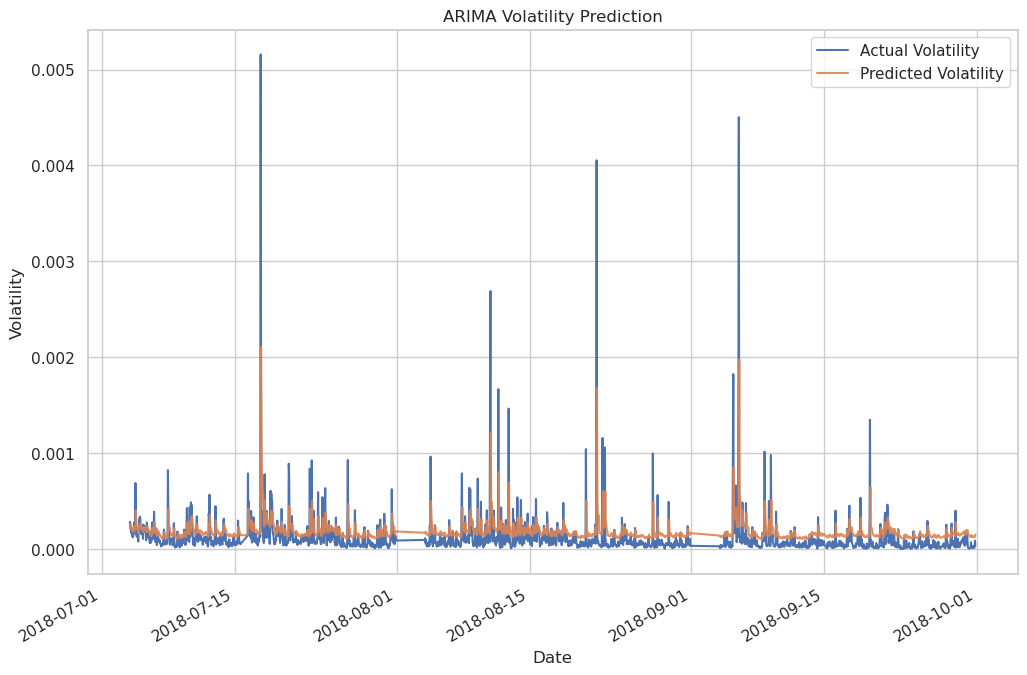

In [ ]:
plt.figure(figsize=(12, 8))
online_har_results_df["vol"].plot(label="Actual Volatility")
online_har_results_df["prediction"].plot(label="Predicted Volatility", alpha=0.9)
plt.title("ARIMA Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

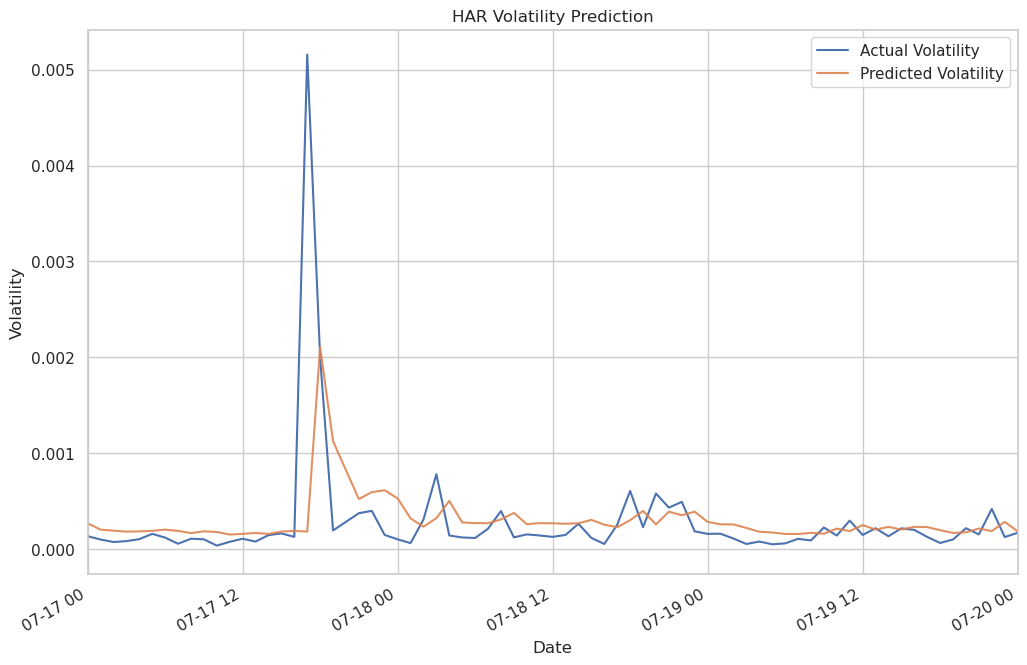

In [ ]:
plt.figure(figsize=(12, 8))
online_har_results_df["vol"].plot(label="Actual Volatility")
online_har_results_df["prediction"].plot(label="Predicted Volatility", alpha=0.9)
plt.title("HAR Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
# zoom in on the last 30 days
plt.xlim(
    datetime.strptime("2018-07-17 00:00:00", "%Y-%m-%d %H:%M:%S"),
    datetime.strptime("2018-07-20 00:00:00", "%Y-%m-%d %H:%M:%S"),
)
plt.legend()
plt.show()

<Axes: xlabel='datetime'>

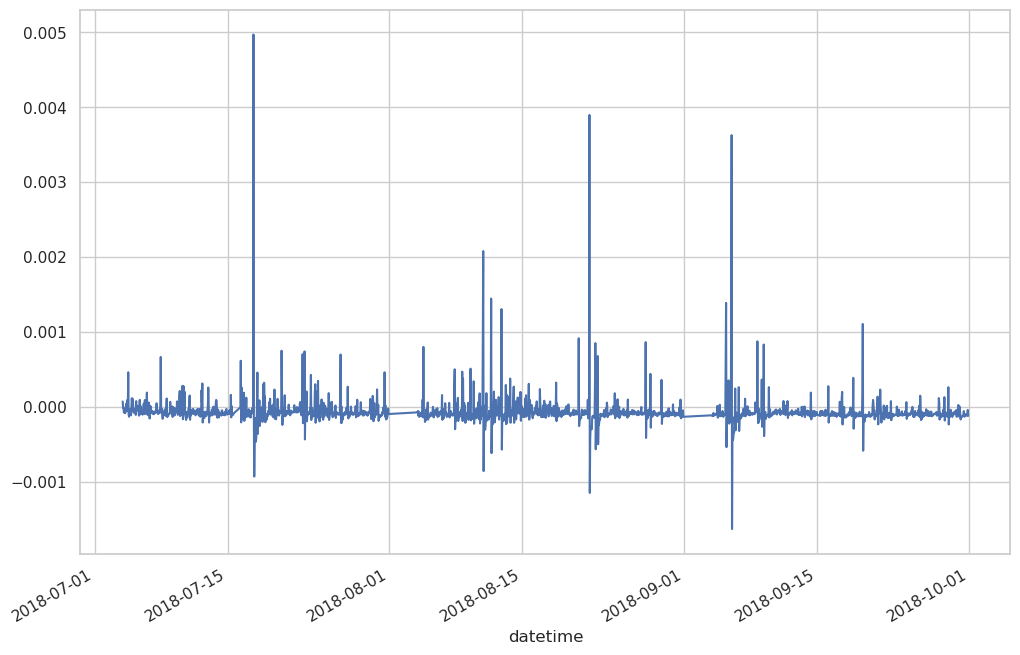

In [ ]:
# plot, add residuals in a subplot
online_har_results_df["residuals"] = online_har_results_df["vol"] - online_har_results_df["prediction"]

plt.figure(figsize=(12, 8))
online_har_results_df["residuals"].plot(label="Residuals (Online ARIMA)")

In [ ]:
# compute RMSE and MAE
rmse_arima = mse(
    online_har_results_df["vol"].values,
    online_har_results_df["prediction"].values,
) ** 0.5
mae_arima = mae(
    online_har_results_df["vol"].values,
    online_har_results_df["prediction"].values,
)
l2_disp = ((online_har_results_df["prediction"] - online_har_results_df["vol"])**2).std()
l1_disp = (online_har_results_df["prediction"] - online_har_results_df["vol"]).std()
print(f"RMSE: {rmse_arima}")
print(f"MAE: {mae_arima}")

RMSE: 0.00023903645400474665
MAE: 0.000122165144401592


In [ ]:
init_training_vola.vol